# Введение

Это самостоятельный проект, который выполнен на основе общедоступных данных с сайта kaggle.com.\
Ссылка на данные: https://www.kaggle.com/datasets/tahzeer/unicorn-startup-companies-july-2023?resource=download

**Краткое описание проекта:** представим, что есть инвестиционный фонд, который инвестирует в стартапы, долю в которых с течением времени он желает продать дороже. Фонд желает понять, какие стартапы чаще других достигают оценки в 1 млрд. долл., и какие из них являются наиболее дорогими, что в перспективе поможет фонду продать свою долю дороже.\
Стартапы, которые достигают оценки в 1 млрд. долларов называют "единорогами". Такое называние закрепилось за такими стартапами, так как высокая оценка их стоимости выделяет их на фоне остальных и делает их в каком-то смысле особенными.

**Цель проекта**  - на основе имеющихся данных определить страны, отрасли и города, где есть наилучшая перспектива найти будущего единорога.

**Декомпозиция проекта:**
1)	Знакомство с данными и предобработка:
 * Изучение общей информации о данных – какие данные имеются, за какой период и сколько их.
 * Работа с дубликатами и пропусками, изменение типов данных при необходимости.
 
2)	Исследовательский анализ данных:
 * Анализ количества стартапов-единорогов и их суммарной стоимости в разрезе стран, городов и отраслей. 
 * Анализ распределения стоимости стартапов и выбор подходящей меры центральной тенденции для ее описания.
 * С помощью меры центральной тенденции проанализировать типичную стоимость компаний-единорогов в разбивке по странам, отраслям.
 * Исследование количества новых компаний в динамике по странам и отраслям.

3)	Проверка статистических гипотез:
 * Проверка значимости различий в стоимостях компаний по отраслям и странам.
 * Проверка значимости различий в долях стартапов-единорогов по отраслям.
 
4) Изучение корреляций:
 * Построение матрицы корреляций – корреляция всех признаков со всеми.
 * Дополнительный анализ выявленной корреляции у городов и отраслей.
 
5)	Итоговый вывод и определение наиболее интересных закономерностей и взаимосвязей согласно цели исследования.

**Описание данных**:
Есть файл "unicorn_startup_companies.csv". В нем следующие данные:
* Колонка "Unnamed: 0" копирует столбец с индексом.
* Колонка "Company" - название компании-единорога.
* Колонка "Valuation ($B)" - стоимость компании-единорога в млрд.долл.
* Колонка "Date Joined" - дата, когда компания стала стоить 1 млрд. долл. или более.
* Колонка "Country" - страна, где компании зарегистрирована.
* Колонка "City" - город, где компании зарегистрирована.
* Колонка "Industry" - отрасль компании.
* Колонка "Select Investors" - инвесторы, которые вкладывались в данную компании.

# Знакомство с данными и предобработка

## Зазгрузим данные и библиотеки

Загрузка библиотек.

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import median_test
from tqdm.notebook import tqdm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import phik
from phik.report import plot_correlation_matrix
from phik import report

Загрузка данных. Ссылка на данные: https://www.kaggle.com/datasets/tahzeer/unicorn-startup-companies-july-2023?resource=download

In [2]:
data = pd.read_csv('unicorn_startup_companies.csv')
pd.set_option('display.max_colwidth', None)
data.head()

,Unnamed: 0,Company,Valuation ($B),Date Joined,Country,City,Industry,Select Investors
0,0,ByteDance,$225,4/7/2017,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, Sina Weibo, SoftBank Group"
1,1,SpaceX,$137,12/1/2012,United States,Hawthorne,Industrials,"Founders Fund, Draper Fisher Jurvetson, Rothenberg Ventures"
2,2,SHEIN,$66,7/3/2018,China,Shenzhen,Consumer & Retail,"Tiger Global Management, Sequoia Capital China, Shunwei Capital Partners"
3,3,Stripe,$50,1/23/2014,United States,San Francisco,Financial Services,"Khosla Ventures, LowercaseCapital, capitalG"
4,4,Canva,$40,1/8/2018,Australia,Surry Hills,Enterprise Tech,"Sequoia Capital China, Blackbird Ventures, Matrix Partners"


### Посмотрим общую информацию о данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1221 non-null   int64 
 1   Company           1221 non-null   object
 2   Valuation ($B)    1221 non-null   object
 3   Date Joined       1221 non-null   object
 4   Country           1221 non-null   object
 5   City              1203 non-null   object
 6   Industry          1221 non-null   object
 7   Select Investors  1219 non-null   object
dtypes: int64(1), object(7)
memory usage: 76.4+ KB


In [4]:
print(f'В нашем датасете данные о стоимости {len(data.Company)} стартапов из {data.Country.nunique()} страны.')

В нашем датасете данные о стоимости 1221 стартапов из 51 страны.


Можем также посмотреть на количество уникальных значений фондов(инвесторов). Для этого сперва создадим список с инвесторами, а затем найдем уникальные значения.\
С помощью list comprehension сделаем список значений колонки с инвесторами, а потом с помощью еще одного list comprehension значения колонки разобьем на отдельных инвесторов.

In [5]:
funds = [investor for investor in [investor_group for investor_group in data['Select Investors']]]

In [6]:
print(f'В нашем датасете {len(set(funds))} инвестор.')

В нашем датасете 1201 инвестор.


Много инвесторов, но в один стартап могут инвестировать несколько фондов, поэтому не удивительно, что уникальных значений фондов много.\
Теперь посмотрим, диапазон дат, который у нас есть в датасете. Это дата, когда оценка стоимости компании превысила 1 млрд. долл. То есть компания вступила в "клуб единорогов".\
Сперва приведем столбец с датами к типу дат.

In [7]:
data['date_joined'] = pd.to_datetime(data['Date Joined'])

In [8]:
print(f'Самая ранняя дата, когда компания из нашей таблицы стала "единорогом" - это {data.date_joined.dt.date.min()}.\
 Самая поздняя дата - {data.date_joined.dt.date.max()}.')

Самая ранняя дата, когда компания из нашей таблицы стала "единорогом" - это 2007-07-02. Самая поздняя дата - 2023-06-29.


## Предобработка данных

### Названия столбцов

Для удобства дальнейшей работы немного изменим названия столбцов. Приведем их к нижнему регистру и пробел заменим нижним подчеркиванием. 

In [9]:
data.columns = data.columns.str.lower()

In [10]:
data = data.rename(
    columns={'valuation ($b)': 'valuation_$b', 'select investors':'select_investors'})

У нас есть столбец "unnamed: 0", который копирует индекс. И есть столбец с датами "date joined", который нам не пригодится, так как мы создали аналогичный столбец, но с типом дат. Поэтому оба столбца можно удалить.

In [11]:
data = data.drop(['unnamed: 0','date joined'], axis=1)

### Пропуски

У нас есть немного пропусков. Посмотрим из каких столбцов.

In [12]:
data.isna().sum()

company              0
valuation_$b         0
country              0
city                18
industry             0
select_investors     2
date_joined          0
dtype: int64

Пропуски в столбцах с городом и инвесторами. Их мало, поэтому можем вывести на экран. Начнем с пропусков в столбце с городом.

In [13]:
data.loc[data['city'].isna()]

,company,valuation_$b,country,city,industry,select_investors,date_joined
239,HyalRoute,$3.50,Singapore,NaN,Industrials,Kuang-Chi,2020-05-26
313,Amber Group,$3,Hong Kong,NaN,Financial Services,"Tiger Global Management, Tiger Brokers, DCM Ventures",2021-06-21
343,Moglix,$2.60,Singapore,NaN,Industrials,"Jungle Ventures, Accel, Venture Highway",2021-05-17
371,Coda Payments,$2.50,Singapore,NaN,Financial Services,"GIC. Apis Partners, Insight Partners",2022-04-15
488,Advance Intelligence Group,$2,Singapore,NaN,Financial Services,"Vision Plus Capital, GSR Ventures, ZhenFund",2021-09-23
500,Trax,$2,Singapore,NaN,Consumer & Retail,"Hopu Investment Management, Boyu Capital, DC Thomson Ventures",2019-07-22
534,Scroll,$1.80,Seychelles,NaN,Financial Services,"OKX Ventures, Sequoia Capital China, IOSG",2023-03-14
559,Kredivo Holdings,$1.66,Singapore,NaN,Financial Services,"Jungle Ventures, Square Peg Capital, OpenSpace Ventures",2022-08-15
617,bolttech,$1.50,Singapore,NaN,Insurance,"Mundi Ventures, Doqling Capital Partners, Activant Capital",2021-07-01
892,Carousell,$1.10,Singapore,NaN,Consumer & Retail,"500 Global, Rakuten Ventures, Golden Gate Ventures",2021-09-15


У Гонконга и Сингапура скорее всего город не указан, так как он же является и государством. А Сейшельские острова, это маленькое государство состоящее из 115 небольших островов.\
Посмотрим, какие города еще указаны в нашем датасете для этих трех стран.

Начнем с Сингапура.

In [14]:
data.query('country == "Singapore"')['city'].value_counts()

Series([], Name: city, dtype: int64)

У Сингапура есть только город Сингапур. Теперь посмотрим на Гонконг.

In [15]:
data.query('country == "Hong Kong"')['city'].value_counts()

Cheung Sha Wan    1
Hong Kong         1
Kowloon           1
Central           1
Name: city, dtype: int64

У Гонконга есть и другие значения, но это все районы и пригороды Гонконга. Посмотрим на Сейшелы.

In [16]:
data.query('country == "Seychelles"')['city'].value_counts()

Victoria    1
Name: city, dtype: int64

Всего два варианта. И сами Сейшелы один из них.\
Стран с пропусками в городах у нас немного, и это страны, которые по сути являются и городами за исключением Сейшельских островов. Поэтому можем заполнить для таких стран пропуск в городе значением страны.

In [17]:
data.loc[data['city'].isna(), 'city'] = data.loc[data['city'].isna(), 'country']

In [18]:
# проверка, что корректно подставил город
#data.loc[data['country']=="Singapore"]['city']

In [19]:
# проверка, что корректно подставил город
#data.loc[data['country']=="Hong Kong"]['city']

In [20]:
# проверка, что корректно подставил город
#data.loc[data['country']=="Seychelles"]['city']

Теперь посмотрим на пропуски в инвесторах.

In [21]:
data.loc[data['select_investors'].isna()]

,company,valuation_$b,country,city,industry,select_investors,date_joined
935,Avenue One,$1,United States,New York,Financial Services,NaN,2023-05-15
969,LinkSure Network,$1,China,Shanghai,Industrials,NaN,2015-01-01


Обе компании оценены в 1 млрд. долларов. То есть они прошли в список единорогов с минимальным запасом по стоимости бизнеса.\
Возможно, у этих компаний не было инвесторов и компании живут только на деньги основателей, без сторонних инвестиций.\
Удалять не будем, так как этот столбец не количественный и при возможных проверках гипотез пропуски не помешают.

### Дубликаты

Проверим сперва полные дубликаты.

In [22]:
data.duplicated().sum()

0

Полных дубликатов нет. Возможно, если приведем назание компаний к нижнему регистру, то попадутся одинаковые.

In [23]:
data['company'].str.lower().duplicated().sum()

5

Есть пять одинаковых компаний. Выведем их на экран.

In [24]:
data[data['company'].str.lower().duplicated()]

,company,valuation_$b,country,city,industry,select_investors,date_joined
70,Bolt,$8.40,Estonia,Tallinn,Industrials,"Didi Chuxing, Diamler, TMT Investments",2018-05-29
231,Relativity,$3.60,United States,Chicago,Enterprise Tech,"Silver Lake, ICONIQ Capital",2021-03-18
336,Thoug,$2.70,United Kingdom,London,Financial Services,"British Patient Capital, SEB Venture Capital, IQ Capital",2021-11-29
928,Branch,$1.05,United States,Columbus,Insurance,"American Family Ventures, Greycroft, SignalFire",2022-03-01
1132,Fabric,$1,United States,New York,Consumer & Retail,"Innovation Endeavors, Aleph, Temasek",2021-10-26


Приведем все названия компаний к нижнему регистру. Узнаем, изменится ли значений полных дубликатов.

In [25]:
data['company'] = data['company'].str.lower()

In [26]:
data.duplicated().sum()

0

Число полных дубликатов не изменилось. Выведем на экран все строчки, где повторяются названия компаний с учетом дублирующих.

In [27]:
dupl_companies = data[data['company'].duplicated()]['company'].values

In [28]:
data.query('company in @dupl_companies').sort_values(by='company')

,company,valuation_$b,country,city,industry,select_investors,date_joined
40,bolt,$11,United States,San Francisco,Financial Services,"Activant Capital, Tribe Capital, General Atlantic",2021-10-08
70,bolt,$8.40,Estonia,Tallinn,Industrials,"Didi Chuxing, Diamler, TMT Investments",2018-05-29
207,branch,$4,United States,Redwood City,Enterprise Tech,"New Enterprise Associates, Pear, Cowboy Ventures",2018-09-10
928,branch,$1.05,United States,Columbus,Insurance,"American Family Ventures, Greycroft, SignalFire",2022-03-01
670,fabric,$1.50,United States,Bellevue,Consumer & Retail,"Redpoint Ventures, Norwest Venture Partners, Sierra Ventures",2022-02-24
1132,fabric,$1,United States,New York,Consumer & Retail,"Innovation Endeavors, Aleph, Temasek",2021-10-26
178,relativity,$4.20,United States,Inglewood,Industrials,"Playground Global, Bond, Tribe Capital",2020-11-23
231,relativity,$3.60,United States,Chicago,Enterprise Tech,"Silver Lake, ICONIQ Capital",2021-03-18
180,thoug,$4.20,United States,Sunnyvale,Enterprise Tech,"Lightspeed Venture Partners, Khosla Ventures, Geodesic Capital",2018-05-08
336,thoug,$2.70,United Kingdom,London,Financial Services,"British Patient Capital, SEB Venture Capital, IQ Capital",2021-11-29


Видим, что города, инвесторы и даты достижения стоимости в 1 млрд. рублей для всех дубликатов разные. Скорее всего, это разные компании с одним названием и удалять их не будем.\
В итоге, делаем вывод, что явных или не явных дубликатов нет.

### Столбец с оценкой компании

Для того, чтобы можно было проводить математические операции с оценкой бизнеса уберем значок доллара в значениях колонки и сделаем тип float. 

In [29]:
data["valuation_$b"] = data['valuation_$b'].apply(lambda x: x.split('$'))

In [30]:
for idx, value in enumerate(data["valuation_$b"]):
    data["valuation_$b"][idx] = value[1]

C:\Users\User\AppData\Local\Temp\ipykernel_13876\3002595860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["valuation_$b"][idx] = value[1]


In [31]:
data["valuation_$b"] = data["valuation_$b"].astype(float)

### Краткие выводы к разделу с предобработкой

* Были изменены названия столбцов на более удобные.
* Пропуски в столбце с городом относятся к странам, которые либо очень малы как Сейшелы, либо является городом-страной - Гноконг и Сингапур. Пропуски были заполнены названием страны.
* Пропусков столбце с инвесторами всего 2. Оставили их как есть, так как их мало и они не повлияют на анализ. Вероятно, это компании, которые живут без привлечения средств инвесторов.
* Дубликатов нет.
* Оставили в столбце со стоимостью бизнеса только числа и привели их к нужному типу.

# Исследовательский анализ данных

## Страны

Посмотрим сколько у нас всего стран.

In [32]:
data['country'].nunique()

51

### Доли стран по количеству стартапов

Посмотрим на топ-15 стран по количеству страртапов.

In [33]:
top_countries_count = data.pivot_table(
index='country', values='company',aggfunc='count').sort_values(by='company', ascending=False).reset_index()
top_countries_count['total_count'] = top_countries_count['company'].sum()
top_countries_count['proportion'] = round(top_countries_count['company']/top_countries_count['total_count']*100,2)
top_countries_count.head(15)

,country,company,total_count,proportion
0,United States,656,1221,53.73
1,China,173,1221,14.17
2,India,70,1221,5.73
3,United Kingdom,52,1221,4.26
4,Germany,30,1221,2.46
5,France,25,1221,2.05
6,Israel,24,1221,1.97
7,Canada,21,1221,1.72
8,Brazil,16,1221,1.31
9,South Korea,14,1221,1.15


Сильно выделяется только США и Китай. Можно еще выделить Индию и Великобританию. Дальше уже страны с заметно меньшим числом стартапов.\
Построим pie chart, где отразим долю этих 4-ех страны, а все остальные страны будут в категории "Другие".

In [34]:
top_4 = top_countries_count.head(4)['country'].values

In [35]:
top_countries_count['country_group'] = top_countries_count['country'].apply(lambda x: x if x in top_4 else "Others")

In [36]:
companies_count=[]
for idx, value in enumerate(top_countries_count['country_group']):
    if value in top_4:
        companies_count.append(top_countries_count[top_countries_count['country_group']==value]['company'].values[0])
    else:
        companies_count.append(top_countries_count[top_countries_count['country_group']=='Others']['company'].sum())

In [37]:
top_countries_count['companies_count'] = companies_count

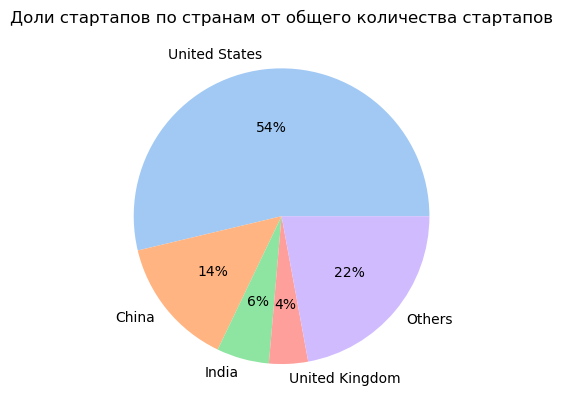

In [38]:
colors = sns.color_palette('pastel')

plt.pie(
    top_countries_count.head(5)['companies_count'], labels=top_countries_count.head(5)['country_group'], colors=colors,
        autopct='%.0f%%')
plt.title('Доли стартапов по странам от общего количества стартапов')
plt.show()

США безоговорочный лидер. Сделаем такую же диаграмму, но измерим доли для общей стоимости стартапов в каждой стране.

### Доли стран по стоимости стартапов

In [39]:
top_countries_value = data.pivot_table(
index='country', values='valuation_$b',aggfunc='sum').sort_values(by='valuation_$b', ascending=False).reset_index()
top_countries_value['total_sum'] = top_countries_value['valuation_$b'].sum()
top_countries_value['proportion'] = round(top_countries_value['valuation_$b']/top_countries_value['total_sum']*100,2)
top_countries_value.head(10)

,country,valuation_$b,total_sum,proportion
0,United States,2052.31,3826.9,53.63
1,China,707.67,3826.9,18.49
2,India,193.75,3826.9,5.06
3,United Kingdom,188.67,3826.9,4.93
4,Germany,78.98,3826.9,2.06
5,France,59.55,3826.9,1.56
6,Australia,55.40,3826.9,1.45
7,Israel,54.42,3826.9,1.42
8,Canada,52.23,3826.9,1.36
9,Brazil,39.08,3826.9,1.02


Все те же лидеры, поэтому сделаем похожую круговую диаграмму.

In [40]:
top_countries_value['country_group'] = top_countries_value['country'].apply(lambda x: x if x in top_4 else "Others")

In [41]:
companies_value=[]
for idx, value in enumerate(top_countries_value['country_group']):
    if value in top_4:
        companies_value.append(top_countries_value[top_countries_value['country_group']==value]['valuation_$b'].values[0])
    else:
        companies_value.append(top_countries_value[top_countries_value['country_group']=='Others']['valuation_$b'].sum())

In [42]:
top_countries_value['companies_value'] = companies_value
top_countries_value.drop(columns=['country','valuation_$b','total_sum','proportion'], inplace=True)

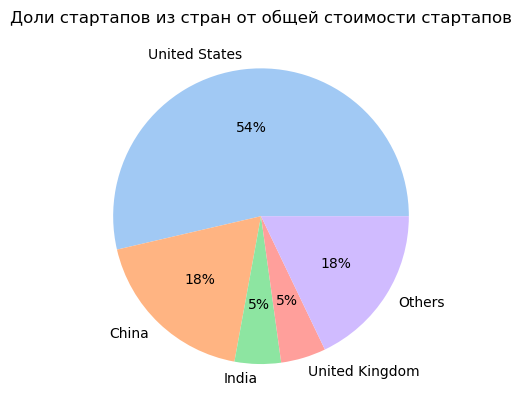

In [43]:
colors = sns.color_palette('pastel')

plt.pie(
    top_countries_value.head(5)['companies_value'], labels=top_countries_value.head(5)['country_group'], colors=colors,
        autopct='%.0f%%')
plt.title('Доли стартапов из стран от общей стоимости стартапов')
plt.show()

Доля США по количеству стартапов и их стоимости 54%. А вот у Китая доля по стоимости 18%, а по количеству - 14%. Значит, в Китае компании дороже среднего. А средняя стоимость формируется под большим влиянием США, поэтому в Китае, скорее всего, единороги стоят дороже, чем в США в среднем. Это мы еще проверим.

## Отрасли

In [44]:
print(f'Всего в нашей таблице {data.industry.nunique()} отраслей.')

Всего в нашей таблице 7 отраслей.


Посмотрим сколько компаний приходится на кажду отрасль.

In [45]:
industry_count = data.groupby('industry')['company'].count().reset_index().sort_values(by='company', ascending=False)

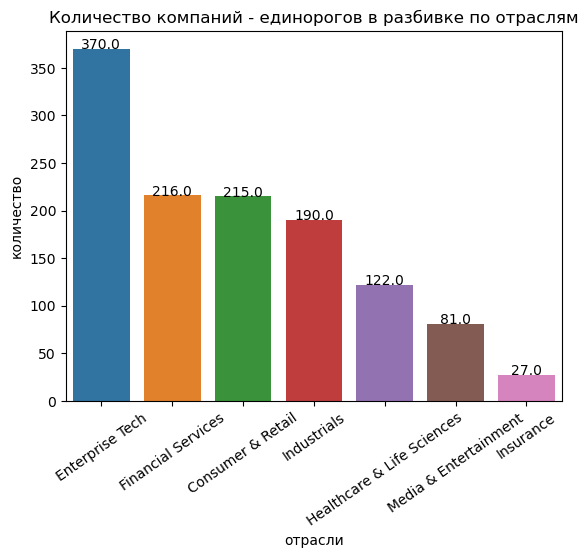

In [46]:
ax = sns.barplot(x='industry', y='company', data=industry_count)

plt.xticks(rotation=35)

plt.title('Количество компаний - единорогов в разбивке по отраслям')

plt.ylabel('количество') 

plt.xlabel('отрасли')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')

plt.show()

Лидирует Enterprise Tech. Это технолгии направленные на улучшение рабочих процессов в компаниях. Например, электронный документоооброт, ПО для работы базами данных и взаимоотношений с клиентами и так далее.\
Стартапы в области финансовых услуг и из области розничной торговли и товаров широкого потребления тоже популярны.

Теперь посмотрим на стоимость стартапов каждой отрасли.

In [47]:
industry_value = data.groupby('industry')['valuation_$b'].sum().reset_index().sort_values(
    by='valuation_$b', ascending=False)

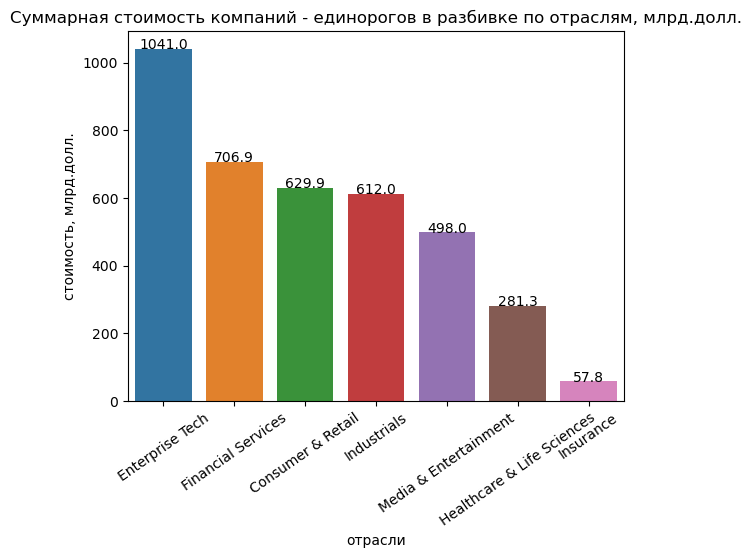

In [48]:
ax = sns.barplot(x='industry', y='valuation_$b', data=industry_value)

plt.xticks(rotation=35)

plt.title('Суммарная стоимость компаний - единорогов в разбивке по отраслям, млрд.долл.')

plt.ylabel('стоимость, млрд.долл.') 

plt.xlabel('отрасли')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')

plt.show()

Открытий не произошло. Как и в случае с количеством компаний, суммарная стоимость компаний выше всего у компаний из отрасли Enterprise Tech, затем идут финансовые услуги и область розничной торговли и товаров широкого потребления. В разделе со стоимостью компаний посмотрим на медианную стоимость по отраслям.

## Города

In [49]:
print(f'В нашем датасете {data.city.nunique()} город.')

В нашем датасете 291 город.


Много городов, что не удивительно, выведем топ-10 городов по количеству стартапов.

In [50]:
top_cities = data.groupby(['city','country'])['company'].count().reset_index().sort_values(
    by='company', ascending=False).head(10)
top_cities

,city,country,company
224,San Francisco,United States,171
181,New York,United States,119
16,Beijing,China,62
242,Shanghai,China,42
149,London,United Kingdom,42
20,Bengaluru,India,31
190,Palo Alto,United States,21
28,Boston,United States,21
192,Paris,France,20
243,Shenzhen,China,20


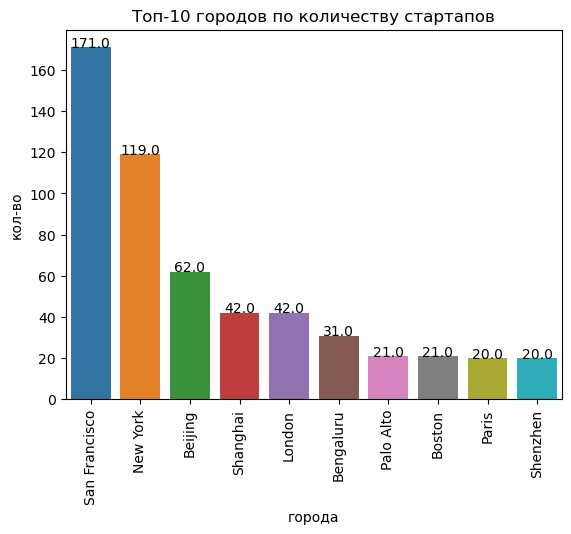

In [51]:
ax = sns.barplot(x='city', y='company', data=top_cities)

plt.xticks(rotation=90)

plt.title('Топ-10 городов по количеству стартапов')

plt.ylabel('кол-во') 

plt.xlabel('города')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')

plt.show()

Как и можно было ожидать, в лидерах города из США и Китая, Также по одному городу из Великобритании, Индии и Франции.\
Сделаем такой же график, но для стоимостей.

In [52]:
top_cities = data.groupby(['city','country'])['valuation_$b'].sum().reset_index().sort_values(
    by='valuation_$b', ascending=False).head(10)
top_cities

,city,country,valuation_$b
224,San Francisco,United States,692.84
16,Beijing,China,387.49
181,New York,United States,269.34
149,London,United Kingdom,169.76
110,Hawthorne,United States,138.35
243,Shenzhen,China,122.75
20,Bengaluru,India,99.31
242,Shanghai,China,95.11
28,Boston,United States,69.80
190,Palo Alto,United States,59.12


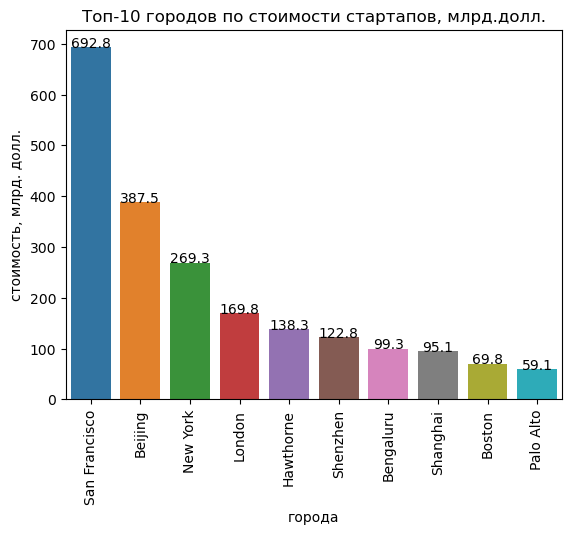

In [53]:
ax = sns.barplot(x='city', y='valuation_$b', data=top_cities)

plt.xticks(rotation=90)

plt.title('Топ-10 городов по стоимости стартапов, млрд.долл.')

plt.ylabel('стоимость, млрд. долл.') 

plt.xlabel('города')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')

plt.show()

В топ-10 городах по стоимости уже нет Франции. Есть только США, Китай, Великобритания. 

## Стоимость компаний

### Общий анализ стоимости

Посмотрим, на разброс стоимостей у компаний.

In [54]:
data["valuation_$b"].describe()

count    1221.000000
mean        3.134234
std         8.458077
min         1.000000
25%         1.100000
50%         1.580000
75%         3.000000
max       225.000000
Name: valuation_$b, dtype: float64

Значения от 1 до 225 млрд. долларов. Но 75% значений в пределах 3 млрд. долларов. Значит на графике распределения мы увидим, что оно сильно скошено вправо.\
Медиана 1,58 млрд. долл., а среднее значение сильно выше из-за хвоста справа - 3,13 млрд. долл.\
На "ящик с усами" тут уже не за чем смотреть. Можно дополнительно визуализировать распределение.

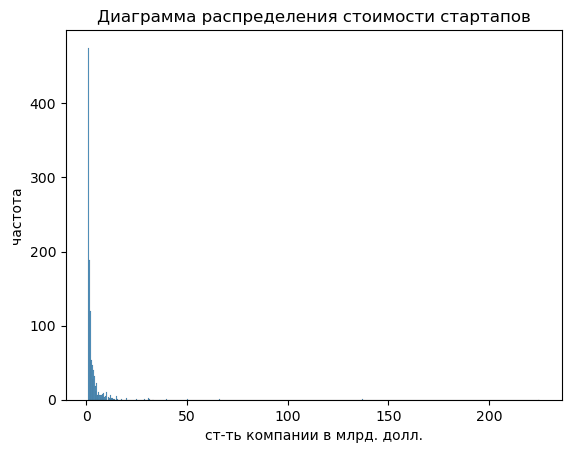

In [55]:
sns.histplot(data["valuation_$b"])
plt.title('Диаграмма распределения стоимости стартапов')
plt.ylabel('частота')
plt.xlabel('ст-ть компании в млрд. долл.')
plt.show()

Сложно что-то разобрать. Ограничим ось х 3 млрд. долл. - это начало четвертого квартиля значений. И построим уже диаграмму плотности вероятности, чтобы понимать, какова примерная доля значения в диапазонах.

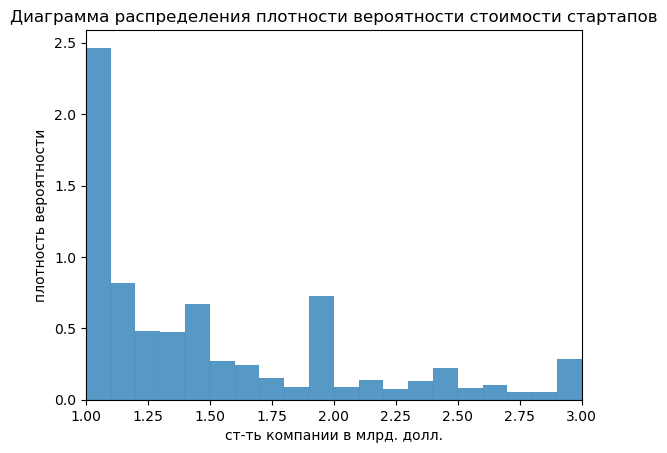

In [56]:
sns.histplot(data["valuation_$b"], bins=100, binwidth=0.1, stat='density')
plt.title('Диаграмма распределения плотности вероятности стоимости стартапов')
plt.xlim(1, 3)
plt.ylabel('плотность вероятности')
plt.xlabel('ст-ть компании в млрд. долл.')
plt.show()

Компании с оценкой стоимости из диапазон от 1 млрд. долл до примерно медианы 1,58 млрд. встречаются чаще всего. Дальше идет длинный достаточно плоский хвост, то есть рязряженное пространство с редкими скачками плотности.

### Стоимость в разбивке по странам

Посмотрим на медианные значения стоимости по странам с самой большой медианной стоимостью. Берем медианну, из-за большого разброса значений в данных.\
Также посмотрим, сколько в каждой из этих стран в стартапов. Мы уже делали таблицу с количеством компаний в каждой стране.

In [57]:
median_country_value = data.groupby('country')['valuation_$b'].median().sort_values(ascending=False).reset_index()
#display(median_country_value.head(15))

In [58]:
median_country_value = pd.merge(median_country_value, top_countries_count[['country','company']], 
                                left_on='country', right_on='country')

In [59]:
display(median_country_value.head(15))

,country,valuation_$b,company
0,Seychelles,5.900,2
1,Estonia,4.950,2
2,Austria,3.805,2
3,Belgium,3.430,3
4,Denmark,3.350,2
5,Lithuania,3.065,2
6,Finland,2.880,4
7,Turkey,2.750,3
8,Netherlands,2.660,7
9,Vietnam,2.635,2


Среди топ 15 стран по медианной стоимости стартапов нет США, Китая, Великобритании и Индии.\
Получается, что в тех странах, которые выше в таблице единороги редки, но стоимость их достаточно высока. Но там, где мало стартапов эти данные не показательны.\
Для стран, где менее 10 стартапов создадим категорию "Другие" и посчитаем среднюю стоимость их медианной стоимости.

In [60]:
country_group=[]
for idx, value in enumerate(median_country_value['company']):
    if value >=10:
        country_group.append(median_country_value[median_country_value['company']==value]['country'].values[0])
    else:
        country_group.append('Others')

In [61]:
median_country_value['country_group'] = country_group
#display(median_country_value.head(15))

Теперь посчитаем среднее значение медианных стоимостей компаний из стран категории "Others" и добавим в таблицу.

In [62]:
mean_others = median_country_value.loc[(median_country_value['country_group']=='Others'),'valuation_$b'].mean()

In [63]:
median_country_value.loc[median_country_value['country_group']=='Others','valuation_$b'] = mean_others
median_country_value.drop(columns=['country','company'], inplace=True)
#display(median_country_value.head(15))

In [64]:
median_country_value.drop_duplicates(subset=['country_group'], inplace=True)
median_country_value = median_country_value.sort_values(by='valuation_$b', ascending=False)

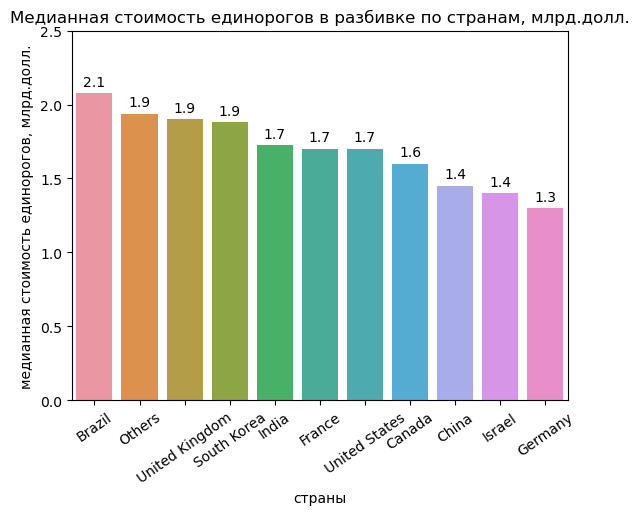

In [65]:
ax = sns.barplot(x='country_group', y='valuation_$b', data=median_country_value)

plt.xticks(rotation=35)

plt.title('Медианная стоимость единорогов в разбивке по странам, млрд.долл.')

plt.ylabel('медианная стоимость единорогов, млрд.долл.') 

plt.xlabel('страны')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')

plt.ylim(0,2.5)
plt.show()

Обычно, самые дорогие стартапы из Бразилии и Велибкобритании. Из Германии, Израиля и Китая наименее дорогие.\
Типичная стоимость единорогов для стран, где менее 10 стартапов - это 1.9 млрд. долл. И это высокая цифра, выше только у Бразилии.

### Стоимость в разбивке по отраслям

Посмотрим на медиану стоимости компаний в разделении по отраслям.

In [66]:
median_industry_value = data.groupby('industry')['valuation_$b'].median().sort_values(ascending=False).reset_index()

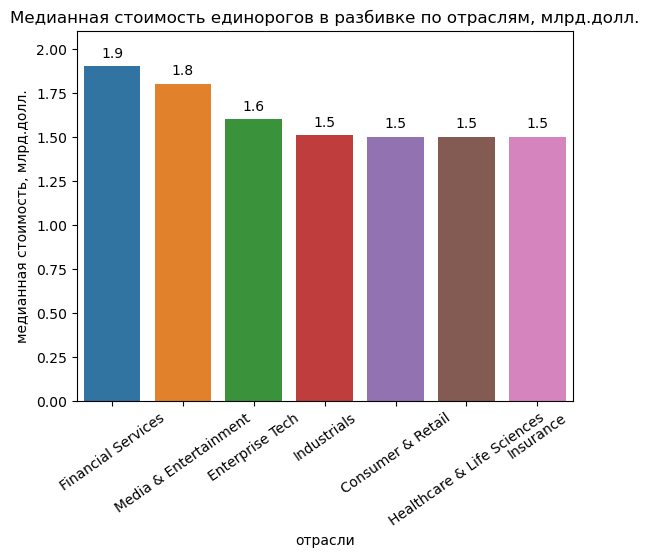

In [67]:
ax = sns.barplot(x='industry', y='valuation_$b', data=median_industry_value)

plt.xticks(rotation=35)

plt.title('Медианная стоимость единорогов в разбивке по отраслям, млрд.долл.')

plt.ylabel('медианная стоимость, млрд.долл.') 

plt.xlabel('отрасли')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')
    
plt.ylim(0,2.1)
plt.show()

В отличие от медианной стоимости по странам у отраслей разброс меньше. Все стоимости уложились в диапазон от 1.5 до 1.9 млрд. долл. включительно. Компании из секторов финансовых услуг и развлечений стоят дороже остальных.

Можно также построить такую же таблицу для среднего, а не медианы.

In [68]:
mean_industry_value = data.groupby('industry')['valuation_$b'].mean().sort_values(ascending=False).reset_index()

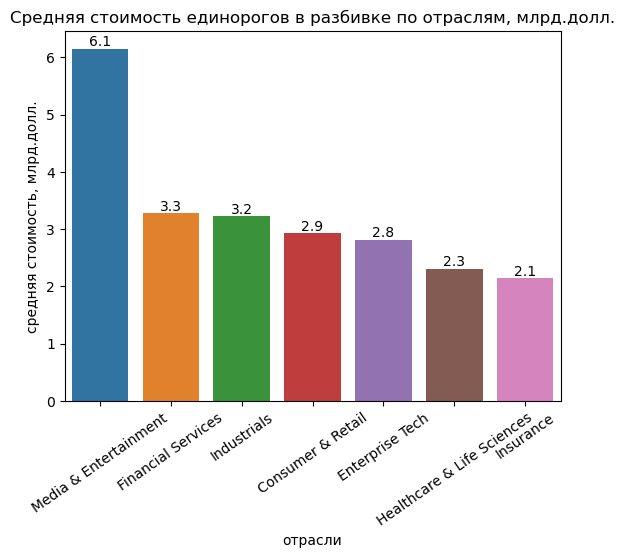

In [69]:
ax = sns.barplot(x='industry', y='valuation_$b', data=mean_industry_value)

plt.xticks(rotation=35)

plt.title('Средняя стоимость единорогов в разбивке по отраслям, млрд.долл.')

plt.ylabel('средняя стоимость, млрд.долл.') 

plt.xlabel('отрасли')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')
    
plt.show()

Когда выбираем для анализа среднее значение, то сразу начинают влиять выбросы. Самая большая стоимость уже не у финансовых услуг, а у сектора развлечений и с больши отрывом. Поэтому медиана лучше описывает типичную компанию сектора.

## В разрезе годов

Напомню, что у нас есть дата, когда компания стала стоить в первый раз 1 млрд. долл. или больше.\
Интересно также узнать, как в разрезе годов изменялось количество новых единорогов, а также стоимость новых единорогов.\
Также есть смысл посмотреть в разрезе основных стран - США, Китай, Индия, Великобритания эти данные.

### Количество компаний, которые стали единорогами по годам

Создадим отдельный столбец, где будет отображаться только год, чтобы удобно было по нему группировать.

In [70]:
data['year'] = data['date_joined'].dt.year

За 2023 год у нас не полные данные, только до июля, поэтому удалим их.

In [71]:
year_count = data.groupby('year')['company'].count().reset_index().sort_values(by = 'year', ascending = True)
year_count.drop([13], inplace = True)
#year_count

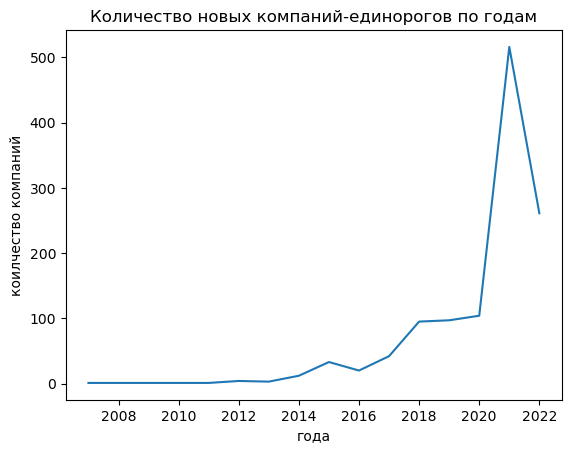

In [72]:
ax = sns.lineplot(x='year', y='company', data=year_count)

plt.xticks(rotation=0)

plt.title('Количество новых компаний-единорогов по годам')

plt.ylabel('коилчество компаний') 

plt.xlabel('года')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')
    
plt.show()

С 2013 года начался подъем количества компаний единорогов. А в 2020 начался очень резкий подъем. Как раз все центральные банка развитых экономик снизили до ноля ключевые ставки и начали печатать деньги, выкупая государственные облигации с рынка. Такой процесс называется в финансах количественное смягчение.\
Денежная масса в экономике выросла, денег в экономике стало больше, аппетит к риску у инвесторов вырос, и они были готовы платить больше денег за стартапы. В конечном счете это привело и к росту цен в целом, то есть к инфляции.\
С 2021 года ажиотаж спал, значительные деньги были потрачены и количество ноых компаний, которые стали оцениваться в 1 млрд. долл. и больше стало меньше.

### Количество компаний по годам в разбивке по странам

In [73]:
year_count = data.groupby(['year', 'country'])['company'].count().reset_index()

Чтобы не распыляться на страны с небольшим количестом компаний оставим только США, Китай, Индию и Великобританию.

In [74]:
year_count['country_group'] = year_count['country'].apply(lambda x: x if x in top_4 else "Others")
year_count = year_count.groupby(['year','country_group'])['company'].sum().reset_index()
year_count = year_count.sort_values(by=['year','country_group'])

Построим график, но ограничим данные периодом с 2013 года, чтобы посмотреть самую актуальную динамику и не выводить слишком большой пласт информации. С 2013 года начался активный рост количества стартапов - единорогов. Возьмем 2013 - 2022 включительно, 2023 не берем, так как за этот год не полные данные.

In [75]:
year_count = year_count.query('year in [2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]')

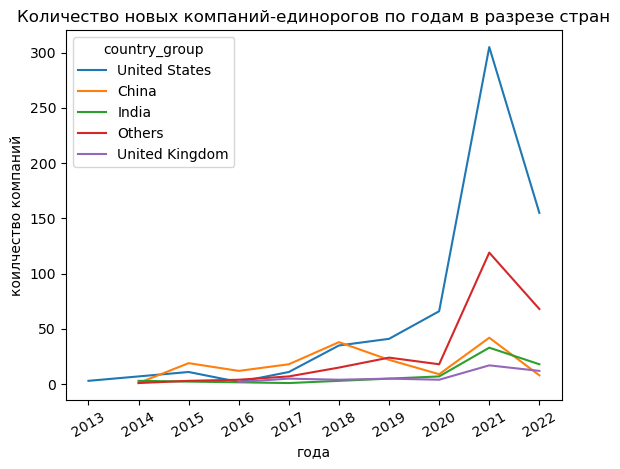

In [76]:
ax = sns.lineplot(x=year_count['year'].astype(str), y='company', data=year_count, hue='country_group')

plt.xticks(rotation=30)

plt.title('Количество новых компаний-единорогов по годам в разрезе стран')

plt.ylabel('коилчество компаний') 

plt.xlabel('года')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')
    
plt.show()

Можно заметить следующее:
* За период с 2015 по 2018 год количество новых компаний в Китае каждый год было больше, чем во всех других странах.
* С 2018 года количество новых компаний в Китае стагнирует, а в 2022 году и вовсе их было меньше, чем во всех рассматриваемых странах на графике. Кокретно про 2022 год, скорее всего - это эффект того, что Китай очень долго оставлял строгие ограничения из-за ковида, и экономика сильно страдала от этого. В 2022 году почти все серьезные ограничения в других странах были сняты, а в Китае еще нет.
* В Индии за период 2020-2022 годов заметно выросло число новых единорогов. Индия обогнала Великобританию и Китай.
* В странаха категории "Другие", начиная с 2020 года новых единорогов появляется значительно больше, чем за другие года. Эти страны в совокупности не обогнали только США, если брать 2020-2022 года.
* США с 2018 года - лидер по кол-ву новых компаний. В 2022 году было снижение, как и у всех других стран.

### Количество компаний по годам в разбивке по отраслям

In [77]:
year_count = data.groupby(['year', 'industry'])['company'].count().reset_index()

Точно также возьмем период с 2013 года по 2022 включительно.

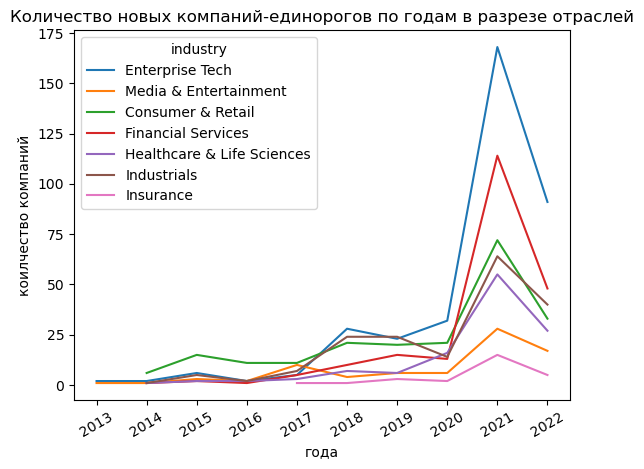

In [78]:
year_count = year_count.query('year in [2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]')

ax = sns.lineplot(x=year_count['year'].astype(str), y='company', data=year_count, hue='industry')

plt.xticks(rotation=30)

plt.title('Количество новых компаний-единорогов по годам в разрезе отраслей')

plt.ylabel('коилчество компаний') 

plt.xlabel('года')

for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center')
    
plt.show()

* До 2017 года лидером по новым единорогам был сектор потребительских товаров и розничной торговли. На конец 2022 года сектор занимает 4 место.
* С 2017 года лидер - сектор технологий для улучшения бизнес-процессов.
* С 2020 года вышел на второе место резким рывком сектор финансовых услуг.
* Ожидаемо в аутсайдерах почти на протяжении всех лет сектора страхования и медиа и развлечений. Возможно, в этих секторах действительно сложно создать крупный, успешный бизнес, оцениваемый в 1 млрд. долл. и более.

## Выводы к разделу с исследовательским анализом данных

* США, Китай, Индия и Великобритания лидеры по количеству стартапов-единорогов. При этом за все время, что есть в датасете компаний из США больше всего, 54% всех компаний.
* По стоимости стартапов-единорогов лидеры те же. По стоимости стартапы из США снова имеют долю 54%.
* За период с 2015 по 2018 год количество новых компаний в Китае каждый год было больше, чем во всех других странах.
* С 2018 года количество новых компаний в Китае стагнирует, а в 2022 году и вовсе их было меньше, чем во всех рассматриваемых странах на графике. Конкретно про 2022 год, скорее всего - это эффект того, что Китай очень долго оставлял строгие ограничения из-за ковида, и экономика сильно страдала от этого. В 2022 году почти все серьезные ограничения в других странах были сняты, а в Китае еще нет.
* В Индии за период 2020-2022 годов заметно выросло число новых единорогов. Индия обогнала Великобританию и Китай.
* В странах категории "Другие", начиная с 2020 года новых единорогов появляется значительно больше, чем за другие года. Эти страны в совокупности не обогнали только США, если брать 2020-2022 года.
* США с 2018 года - лидер по кол-ву новых компаний. В 2022 году было снижение, как и у всех других стран.
* Обычно, самые дорогие стартапы из Бразилии и Велибкобритании. Из Германии, Израиля и Китая наименее дорогие.\
Типичная стоимость единорогов для стран, где менее 10 стартапов(категория "Другие") - это 1.9 млрд. долл. И это высокая цифра, выше только у Бразилии. Но в целом, медианы всех стран укладываются в диапазон 1.3 - 2.1 млрд. долл., где 2.1 у Бразилии.

--------
* В наших данных больше всего компаний из сектора Enterprise Tech.
* Стартапы в области финансовых услуг и из области розничной торговли и товаров широкого потребления тоже популярны.
* В отличие от медианной стоимости по странам у отраслей разброс меньше. Все стоимости уложились в диапазон от 1.5 до 1.9 млрд. долл. включительно. Компании из секторов финансовых услуг и развлечений стоят дороже остальных. Примечательно, что компаний и сектора развлечений и медиа очень мало, меньше только страховых компаний, но их медианная стоимость самая высокая. Видимо сектор требует много творческой работы, которую сложно скопировать, отсюда редкость таких компаний, но если результат труда нравится людям, то компанию оценивают высоко.
* До 2017 года лидером по новым единорогам был сектор потребительских товаров и розничной торговли. На конец 2022 года сектор занимает 4 место.
* С 2017 года лидер - сектор технологий для улучшения бизнес-процессов.
* С 2020 года вышел на второе место резким рывком сектор финансовых услуг.
* Ожидаемо в аутсайдерах  по количеству компаний почти на протяжении всех лет сектора страхования и медиа и развлечений. Возможно, в этих секторах действительно сложно создать крупный, успешный бизнес, оцениваемый в 1 млрд. долл. и более.
--------
* В топ-10 городов по количеству компаний, в основном, города из США и Китая, также по одному городу из Великобритании, Индии и Франции.
* В топ-10 городов по суммарной стоимости компаний также в основном США и Китай и Бангалор из Индии и Лондон из Великобритании.

# Проверка гипотез

## Медианная стоимость единорогов в разбивке по отраслям

Мы выбрали медиану, как более репрезентативную характеристику типичной стоимости для каждой отрасли, так как в распределении стоимости есть выбросы.\
У страховой отрасли самая низкая меидана - 1.5 млрд. долл., а у финансовых услуг самая высокая - 1.9 млрд. долл. Складывается ощущение, что различие не такое большое. Проверим, является ли оно статистически значимым с помощью теста Муда для медиан или теста Манна-Уитни.\
Тест Муда работает при данных с выбросами и с разным кол-вом величин в группах, а также позволяет оценить различия в медианах сразу для более, чем 2 групп, как у нас.\
Он работает, если распределения значений в группах имеют одинаковую форму распределений.
* (https://www.geeksforgeeks.org/moods-median-test/)
* (https://lifewithdata.com/2023/08/08/how-to-perform-moods-median-test-in-r/)

Также, можно было бы использовать тест Манна-Уитни. Он не сравнивает медианы. Тест Манна-Уитни каждому значению в каждой группе присваивает ранг, а затем сравнивает сумму рангов в каждой группе. Поэтому анализирует распределение рангов, а значит замечает различие в распределениях.\
Если распределения признаков у групп имеют одну форму, то тест поможет обнаружить значимое смещение распределения.\
Если разница распределений лишь в их смещении относительно друг друга, то и медианы будут смещены. Поэтому тест Манна-Уитни подойдет.
* (https://qastack.ru/stats/11084/why-is-the-mann-whitney-u-test-significant-when-the-medians-are-equal)
* (https://www.statskingdom.com/test_mann_whitney.html)
* (https://www.bmj.com/content/323/7309/391)

Но проблема в нашем случае будет во множественном тестировании, где надо будет между собой сравнить все выборки.

Мы можем сперва проверить форму распределений. Выведем графики распределений для всех отраслей. 

In [79]:
features = [value for value in data['industry'].unique()]
features

['Media & Entertainment',
 'Industrials',
 'Consumer & Retail',
 'Financial Services',
 'Enterprise Tech',
 'Healthcare & Life Sciences',
 'Insurance']

In [80]:
# устанавливаем число колонок
num_cols = 2
# set a number of rows
if len(features)%num_cols == 0:
    num_rows = len(features)//num_cols #если кол-во графиков делится без остатка на кол-во колонок
else:
    num_rows = (len(features)//num_cols) + 1 #если кол-во графиков не делится без остатка на кол-во колонок

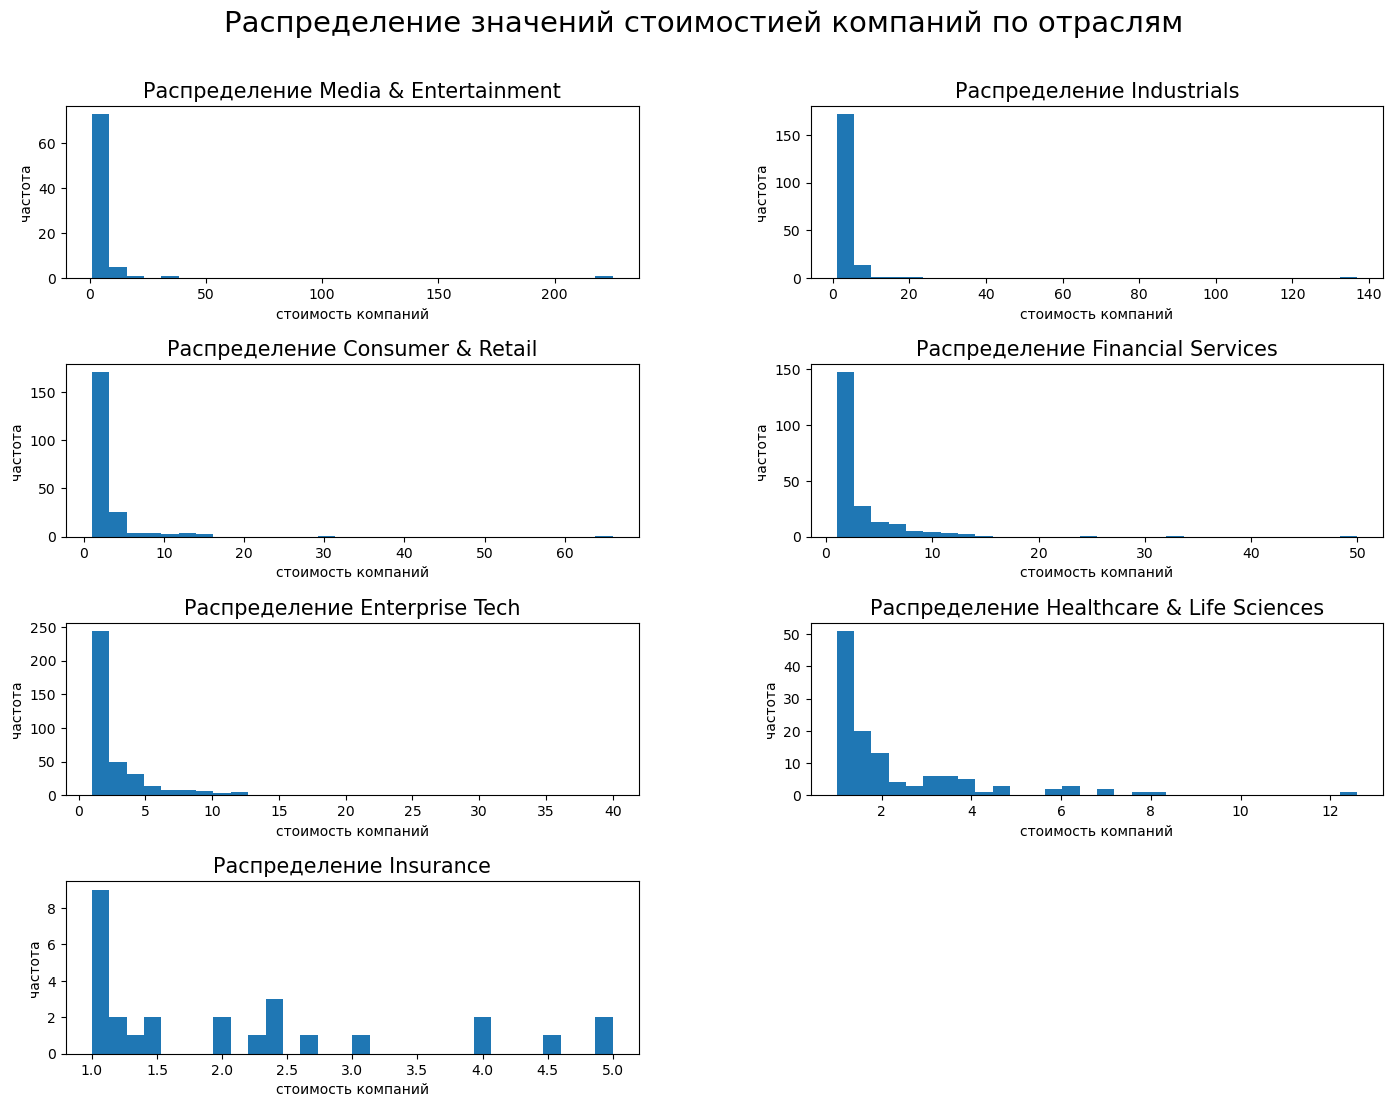

In [81]:
fig, ax = plt.subplots(figsize=(17,12), 
                       nrows=num_rows, 
                       ncols=num_cols)

# задаем общий заголовок всех графиков
fig.suptitle('Распределение значений стоимостией компаний по отраслям', 
             fontsize=21)

# используем цикл для отрисовки каждого графика:
for feat in features:
    row = features.index(feat)//num_cols # 0-ой и 1-ый индекс попадут в 1 строку, 2 и 3 - во вторую и т.д.
    col = features.index(feat)%num_cols # остаток от 0/2 = 0, от 1/2 = 1, от 2/2=0, от 3/2=1 и т.д.
    
    ax[row, col].hist(data[data['industry'] == feat]['valuation_$b'], bins=30)
    ax[row, col].set_title('Распределение '+feat.title(), 
                           fontsize=15)
    ax[row, col].set_xlabel('стоимость компаний',
                            fontsize=10)
    ax[row, col].set_ylabel('частота',
                            fontsize=10)
    
plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)
fig.delaxes(ax[3][1])

Форма распределение схожа - везде большой хвост справа, но распределение стоимостей для страхового сектора - Insurance выглядит иначе из-за маленького количества значений. Мы помним, что в нашем датасете всего 27 компаний данного сектора. Поэтому для проведения теста мы можем не учитывать этот сектор. Медиана там 1.5, как у нескольких других секторов.

Мы можем проверить ошибку первого рода для нашего теста Муда. Провести подобие А/А теста.\
Сначала для примера возьмем три отрасли - "Enterprise Tech", "Financial Services", "Consumer & Retail" и будем генерировать из стоимостей компаний этих секторов выборки по 100 значений.\
Если мы будем генерировать выборки из одной генеральной совокупности, то ошибка первого рода должна быть близка к уровню значимости. В нашем случае 5%. Так как pvalue в этом случае должен распределиться равномерно.

Для удобства сохраним в разные переменные значения стоимостей компаний для каждого сектора.

In [82]:
ME = data[data['industry']=='Media & Entertainment']['valuation_$b']   
Ind = data[data['industry']=='Industrials']['valuation_$b'] 
FS = data[data['industry']=='Financial Services']['valuation_$b'] 
CR = data[data['industry']=='Consumer & Retail']['valuation_$b'] 
HL = data[data['industry']=='Healthcare & Life Sciences']['valuation_$b'] 
ET = data[data['industry']=='Enterprise Tech']['valuation_$b']

Проделаем А/А тест для  "Enterprise Tech".

In [83]:
result = []
for _ in range(5000):
    a = ET.sample(100,replace=True)
    b = ET.sample(100,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

In [84]:
t = pd.Series(result)
(t<0.05).mean()

0.038

Теперь А/А тест для "Financial Services".

In [85]:
result = []
for _ in range(5000):
    a = FS.sample(100,replace=True)
    b = FS.sample(100,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

In [86]:
t = pd.Series(result)
(t<0.05).mean()

0.0414

Теперь А/А тест для "Consumer & Retail".

In [87]:
result = []
for _ in range(5000):
    a = CR.sample(100,replace=True)
    b = CR.sample(100,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

In [88]:
t = pd.Series(result)
(t<0.05).mean()

0.0412

Видим, что ошибки первого рода не очень близки к 5% во всех трех случаях, значит, тест Муда работает не совсем корректно на наших данных. Посмотрим, что будет если проведем такой же А/А тест для Манна-Уитни.\
Возьмем уже всех 6 секторов.

Проделаем А/А тест для  "Enterprise Tech".

In [89]:
result = []
for _ in tqdm(range(3000)):
    a = ET.sample(100,replace=True)
    b = ET.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)
    
t = pd.Series(result)
(t<0.05).mean()

  0%|          | 0/3000 [00:00<?, ?it/s]

0.05266666666666667

Теперь А/А тест для "Healthcare & Life Sciences".

In [90]:
result = []
for _ in tqdm(range(3000)):
    a = HL.sample(100,replace=True)
    b = HL.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)
    
t = pd.Series(result)
(t<0.05).mean()

  0%|          | 0/3000 [00:00<?, ?it/s]

0.046

Теперь А/А тест для "Consumer & Retail".

In [91]:
result = []
for _ in tqdm(range(3000)):
    a = CR.sample(100,replace=True)
    b = CR.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)
    
t = pd.Series(result)
(t<0.05).mean()

  0%|          | 0/3000 [00:00<?, ?it/s]

0.054

Теперь А/А тест для "Financial Services".

In [92]:
result = []
for _ in tqdm(range(3000)):
    a = FS.sample(100,replace=True)
    b = FS.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)
    
t = pd.Series(result)
(t<0.05).mean()

  0%|          | 0/3000 [00:00<?, ?it/s]

0.049666666666666665

Теперь А/А тест для "Industrials".

In [93]:
result = []
for _ in tqdm(range(3000)):
    a = Ind.sample(100,replace=True)
    b = Ind.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)
    
t = pd.Series(result)
(t<0.05).mean()

  0%|          | 0/3000 [00:00<?, ?it/s]

0.049

Теперь А/А тест для "Media & Entertainment".

In [94]:
result = []
for _ in tqdm(range(3000)):
    a = ME.sample(100,replace=True)
    b = ME.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)
    
t = pd.Series(result)
(t<0.05).mean()

  0%|          | 0/3000 [00:00<?, ?it/s]

0.045

Видим, что тест Манна-Уитни показывает ошибку первого рода более близкою к 5%. Поэтому, даже не смотря на большое количество групп в тесте, будем использовать его. Мы не учитываем в тестировании сектор страхования. Поэтому у нас будет 6*5/2=15 тестов. 

И так:\
**Нулевая гипотеза:** Медианные стоимости компаний-единорогов секторов равны.\
**Альтернативная гипотеза:** Есть статистически значимые различия между двумя медианами.

Для множественного тестирования применим поправка Холма.\
Реализовать данный метод можно при помощи процедуры  𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑒𝑡𝑒𝑠𝑡𝑠() из библиотеки  𝑠𝑡𝑎𝑡𝑠𝑚𝑜𝑑𝑒𝑙𝑠с параметром  𝑚𝑒𝑡ℎ𝑜𝑑=”ℎ𝑜𝑙𝑚”.
Сперва вызовем тест Манна-Уитни, чтобы рассчитались все p_value.

In [95]:
ME = data[data['industry']=='Media & Entertainment']['valuation_$b']   
Ind = data[data['industry']=='Industrials']['valuation_$b'] 
FS = data[data['industry']=='Financial Services']['valuation_$b'] 
CR = data[data['industry']=='Consumer & Retail']['valuation_$b'] 
HL = data[data['industry']=='Healthcare & Life Sciences']['valuation_$b'] 
ET = data[data['industry']=='Enterprise Tech']['valuation_$b']

In [96]:
stat_ME_Ind, p_ME_Ind = stats.mannwhitneyu(ME, Ind, alternative='two-sided') #1 Entertainment - Industrials

stat_ME_FS, p_ME_FS = stats.mannwhitneyu(ME, FS, alternative='two-sided') #2 Entertainment - Finance

stat_ME_CR, p_ME_CR = stats.mannwhitneyu(ME, CR, alternative='two-sided') #3 Entertainment - Consumer

stat_ME_HL, p_ME_HL = stats.mannwhitneyu(ME, HL, alternative='two-sided') #4 Entertainment - Healthcare 

stat_ME_ET, p_ME_ET = stats.mannwhitneyu(ME, ET, alternative='two-sided') #5 Entertainment - Enterprise Tech

stat_Ind_FS, p_Ind_FS = stats.mannwhitneyu(Ind, FS, alternative='two-sided') #6 Industrials - Finance

stat_Ind_CR, p_Ind_CR = stats.mannwhitneyu(Ind, CR, alternative='two-sided') #7 Industrials - Consumer 

stat_Ind_HL, p_Ind_HL = stats.mannwhitneyu(Ind, HL, alternative='two-sided') #8 Industrials - Healthcare & 

stat_Ind_ET, p_Ind_ET = stats.mannwhitneyu(Ind, ET, alternative='two-sided') #9 Industrials - Enterprise Tech

stat_FS_CR, p_FS_CR = stats.mannwhitneyu(FS, CR, alternative='two-sided') #10 Finance - Consumer

stat_FS_HL, p_FS_HL = stats.mannwhitneyu(FS, HL, alternative='two-sided') #11 Finance - Healthcare 

stat_FS_ET, p_FS_ET = stats.mannwhitneyu(FS, ET, alternative='two-sided') #12 Finance - Enterprise Tech

stat_CR_HL, p_CR_HL = stats.mannwhitneyu(CR, HL, alternative='two-sided') #13 Consumer - Healthcare

stat_CR_ET, p_CR_ET = stats.mannwhitneyu(CR, ET, alternative='two-sided') #14 Consumer - Enterprise Tech

stat_HL_ET, p_HL_ET = stats.mannwhitneyu(HL, ET, alternative='two-sided') #15 Healthcare - Enterprise Tech

Мы передаем список с p_value отсортированными по возрастанию в метод 𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑒𝑡𝑒𝑠𝑡𝑠() из библиотеки 𝑠𝑡𝑎𝑡𝑠𝑚𝑜𝑑𝑒𝑙𝑠. В ответ мы получаем массив, где True - это отвергнутая нулевая гипотеза, а False - не отвергнутая.\
Для нагляданости выведем отсортированные p_value.

In [97]:
pvals = pd.DataFrame(
    {'pval':[p_ME_Ind, p_ME_FS, p_ME_CR, p_ME_HL, p_ME_ET, p_Ind_FS, p_Ind_CR, p_Ind_HL, p_Ind_ET, p_FS_CR,
            p_FS_HL, p_FS_ET, p_CR_HL, p_CR_ET, p_HL_ET],
    'names':['p_ME_Ind', 'p_ME_FS', 'p_ME_CR', 'p_ME_HL', 'p_ME_ET', 'p_Ind_FS', 'p_Ind_CR', 'p_Ind_HL', 
                      'p_Ind_ET', 'p_FS_CR', 'p_FS_HL', 'p_FS_ET', 'p_CR_HL', 'p_CR_ET', 'p_HL_ET']})

pvals = pvals.sort_values(by='pval', ascending=True)
pvals['significance'] = 0.05/np.arange(1, 16, 1)[::-1]
#pvals

Вызываем метод 𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑒𝑡𝑒𝑠𝑡𝑠() из библиотеки  𝑠𝑡𝑎𝑡𝑠𝑚𝑜𝑑𝑒𝑙𝑠 с параметром  𝑚𝑒𝑡ℎ𝑜𝑑=”ℎ𝑜𝑙𝑚” и сохраним результат в отдельный столбец.

In [98]:
pvals['result'] = multipletests(
sorted([p_ME_Ind, p_ME_FS, p_ME_CR, p_ME_HL, p_ME_ET, p_Ind_FS, p_Ind_CR, p_Ind_HL, p_Ind_ET, p_FS_CR,
        p_FS_HL, p_FS_ET, p_CR_HL, p_CR_ET, p_HL_ET]), alpha=0.05, method='holm', is_sorted = True)[0]
pvals

,pval,names,significance,result
9,0.030034,p_FS_CR,0.003333,False
2,0.083203,p_ME_CR,0.003571,False
10,0.141969,p_FS_HL,0.003846,False
5,0.173128,p_Ind_FS,0.004167,False
11,0.188428,p_FS_ET,0.004545,False
3,0.205894,p_ME_HL,0.005000,False
13,0.226144,p_CR_ET,0.005556,False
0,0.227454,p_ME_Ind,0.006250,False
4,0.288882,p_ME_ET,0.007143,False
6,0.412139,p_Ind_CR,0.008333,False


Везде False. Это значит, что ни одна нулевая гипотеза не была отвергнута и мы делаем вывод, что медианные стоимости компаний по секторам статистически значимо не различаются.\
Просто для сравнения можно также посмотреть, что нам скажет тест Муда для медиан.

И так:\
**Нулевая гипотеза:** Медианные стоимости компаний-единорогов каждого сектора равны.\
**Альтернативная гипотеза:** Есть значимые различия хотябы между двумя медианами.

Посчитаем p_value для теста Муда.

In [99]:
alpha = 0.05
stat, p_value, med, tbl = median_test(ME, Ind, FS, CR, HL, ET)

In [100]:
print(f'p_value: {p_value}')
if p_value < alpha:
    
    print('Отвергаем нулевую гипотезу: есть статистически значимые различия в медианах хотябы двух групп.')
else:
    print('Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в медианах нет.')

p_value: 0.1103155341875731
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в медианах нет.


Тест нам говорит, что те различия медиан, которые у нас есть не зачимы статистически, то есть они вполне могут быть получены у групп из одной генеральной совокупности. Следовательно, мы не можем говорить, что медианы разные.\
При условии, что нулевая гипотеза верна, вероятность увидеть такие или более значимые различия у медиан составляет 11%.\
Итоговый вывод такой же, как у теста Манна-Уитни.

## Медианная стоиомость компаний-единорогов в разбивке по странам

Наибольшее число стартапов в США, Китае, Индии и Великобритании. Медианная стоимость компаний в этих странах 1.7, 1.4, 1.7, 1.9 соответственно.\
То есть разброс небольшой. Проверим, насколько статистически значимо различие медиан. В этих странах в сумме 78% всех стартапов из наших исходных данных.

Мы можем проверить форму распределений. Выведем графики распределений для этих стран. 

In [101]:
features = [value for value in top_countries_count.head(4)['country'].values]
features

['United States', 'China', 'India', 'United Kingdom']

Для удобства сохраним в разные переменные значения стоимостей компаний для каждого сектора.

In [102]:
USA = data[data['country']=='United States']['valuation_$b']   
China = data[data['country']=='China']['valuation_$b'] 
UK = data[data['country']=='United Kingdom']['valuation_$b'] 
Ind = data[data['country']=='India']['valuation_$b']

In [103]:
# устанавливаем число колонок
num_cols = 2
# set a number of rows
if len(features)%num_cols == 0:
    num_rows = len(features)//num_cols #если кол-во графиков делится без остатка на кол-во колонок
else:
    num_rows = (len(features)//num_cols) + 1 #если кол-во графиков не делится без остатка на кол-во колонок

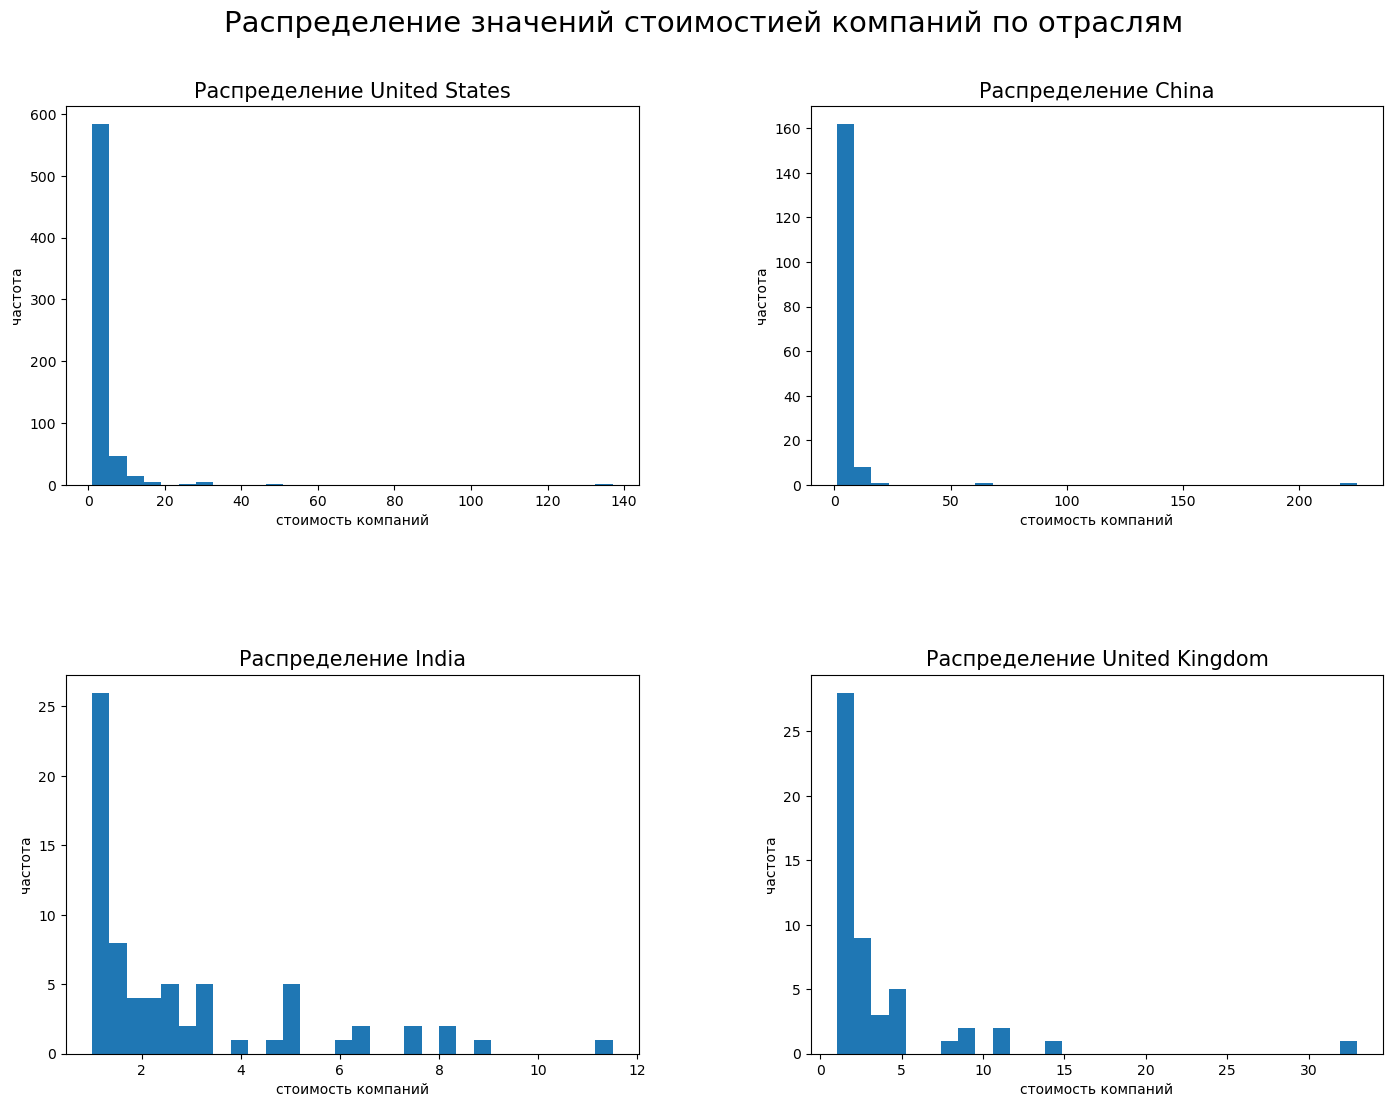

In [104]:
fig, ax = plt.subplots(figsize=(17,12), 
                       nrows=num_rows, 
                       ncols=num_cols)

# задаем общий заголовок всех графиков
fig.suptitle('Распределение значений стоимостией компаний по отраслям', 
             fontsize=21)

# используем цикл для отрисовки каждого графика:
for feat in features:
    row = features.index(feat)//num_cols # 0-ой и 1-ый индекс попадут в 1 строку, 2 и 3 - во вторую и т.д.
    col = features.index(feat)%num_cols # остаток от 0/2 = 0, от 1/2 = 1, от 2/2=0, от 3/2=1 и т.д.
    
    ax[row, col].hist(data[data['country'] == feat]['valuation_$b'], bins=30)
    ax[row, col].set_title('Распределение '+feat.title(), 
                           fontsize=15)
    ax[row, col].set_xlabel('стоимость компаний',
                            fontsize=10)
    ax[row, col].set_ylabel('частота',
                            fontsize=10)
plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

Формы распределений схожи - пик около 1 млрд. долл. и дальнейшее снижение частоты появление компаний с большей стоимостью.

Проведем для всех 4-ех стран А/А тест, чтобы проверить ошибку 1-го рода при использовании теста Муда.

Для США.

In [105]:
result = []
for _ in tqdm(range(3000)):
    a = USA.sample(200,replace=True)
    b = USA.sample(200,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [106]:
t = pd.Series(result)
(t<=0.05).mean()

0.036

Для Китая.

In [107]:
result = []
for _ in tqdm(range(3000)):
    a = China.sample(100,replace=True)
    b = China.sample(100,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [108]:
t = pd.Series(result)
(t<=0.05).mean()

0.036333333333333336

Для Индии.

In [109]:
result = []
for _ in tqdm(range(5000)):
    a = Ind.sample(70,replace=True)
    b = Ind.sample(70,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [110]:
t = pd.Series(result)
(t<=0.05).mean()

0.0388

Для Великобритании.

In [111]:
result = []
for _ in tqdm(range(5000)):
    a = UK.sample(50,replace=True)
    b = UK.sample(50,replace=True)
    stat, p_value, med, tbl = median_test(a,b)
    result.append(p_value)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [112]:
t = pd.Series(result)
(t<=0.05).mean()

0.033

Для Великобритании и Индии, где значений меньше всего, мы получили слишком маленькие p_value. Получаем всегда около или ниже 3.5%. То есть мы ожидаем, что будем отвергать нулевую гипотез в 5% случаев, а на самом деле это будет происходить в 3.5% случаев.\
Мы рискуем завысить возможность принять нулевую гипотзу, когда ее стоило отклонить.\
У нас формы распределения схожи, значит, можно использовать тест Манна-Уитни.

Он не сравнивает медианы. Тест Манна-Уитни каждому значению в каждой группе присваивает ранг, а затем сравнивает сумму рангов в каждой группе. Поэтому тест анализирует распределение рангов, а значит замечает различие в распределениях.
Если распределения признаков у групп имеют одну форму, то тест поможет обнаружить значимое смещение распределения.
Если разница распределений лишь в их смещении относительно друг друга, то и медианы будут смещены. Поэтому тест Манна-Уитни подойдет.\
При этом тест Манна-Уитни подойдет для групп с разным количеством значений, но мощность теста из-за этого снизится.
* (https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes)

Проверим ошибку первого рода для теста Манна-Уитни.

Для США.

In [113]:
result = []
for _ in tqdm(range(3000)):
    a = USA.sample(100,replace=True)
    b = USA.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [114]:
t = pd.Series(result)
(t<=0.05).mean()

0.050333333333333334

Очень близко к 5% - это хорошо.

Для Китая.

In [115]:
result = []
for _ in tqdm(range(3000)):
    a = China.sample(100,replace=True)
    b = China.sample(100,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [116]:
t = pd.Series(result)
(t<=0.05).mean()

0.05266666666666667

Тоже близко к 5%.

Для Индии.

In [117]:
result = []
for _ in tqdm(range(5000)):
    a = Ind.sample(30,replace=True)
    b = Ind.sample(30,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [118]:
t = pd.Series(result)
(t<=0.05).mean()

0.046

И тут около 5%.

Для Великобритании.

In [119]:
result = []
for _ in tqdm(range(5000)):
    a = UK.sample(30,replace=True)
    b = UK.sample(30,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [120]:
t = pd.Series(result)
(t<=0.05).mean()

0.0508

В каждом нашем А/А тесте получили ошибку первого рода около 5%. Так как и должно быть в случае выборок из одной генеральной совокупности. Тест Манна-Уитни лучше нам подходит, чем тест Муда.

У нас 4 страны, поэтому надо будет провести 4*3/2=6 тестов. Для этого нужна поправка на множественное тестирование и лучше не Бонферронни, чтобы не занижать ошибку перевого рода.\
Применим Метод Холма.\
Реализовать данный метод можно при помощи процедуры $multipletests()$ из библиотеки $statsmodels$ с параметром $method=”holm”$.\
Сперва вызовем тест Манна-Уитни, чтобы рассчитались все p_value.

**Нулевая гипотеза**: распределения стоимости стартапов двух стран равны.\
**Альтернативная гипотеза**:распределения стоимости стартапов двух стран не равны.

In [121]:
stat_US_Ch, p_US_Ch = stats.mannwhitneyu(USA, China, alternative='two-sided')

stat_US_I, p_US_I = stats.mannwhitneyu(USA, Ind, alternative='two-sided')

stat_US_UK, p_US_UK = stats.mannwhitneyu(USA, UK, alternative='two-sided')

stat_Ch_I, p_Ch_I = stats.mannwhitneyu(China, Ind, alternative='two-sided')

stat_Ch_UK, p_Ch_UK = stats.mannwhitneyu(China, UK, alternative='two-sided')

stat_I_UK, p_I_UK = stats.mannwhitneyu(Ind, UK, alternative='two-sided')

Мы передаем список с p_value отсортированными по возрастанию в метод 𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑒𝑡𝑒𝑠𝑡𝑠() из библиотеки 𝑠𝑡𝑎𝑡𝑠𝑚𝑜𝑑𝑒𝑙𝑠. В ответ мы получаем массив, где True - это отвергнутая нулевая гипотеза, а False - не отвергнутая.\
Для нагляданости выведем отсортированные p_value.

In [122]:
pvals = pd.DataFrame({'pval':[p_US_Ch, p_US_I, p_US_UK, p_Ch_I, p_Ch_UK, p_I_UK],
             'names':['p_US_Ch', 'p_US_I', 'p_US_UK', 'p_Ch_I', 'p_Ch_UK', 'p_I_UK']})
pvals = pvals.sort_values(by='pval', ascending=True)
pvals['significance'] = 0.05/np.arange(1, 7, 1)[::-1]

Вызываем метод 𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑒𝑡𝑒𝑠𝑡𝑠() из библиотеки  𝑠𝑡𝑎𝑡𝑠𝑚𝑜𝑑𝑒𝑙𝑠 с параметром  𝑚𝑒𝑡ℎ𝑜𝑑=”ℎ𝑜𝑙𝑚” и сохраним результат в отдельный столбец.

In [123]:
pvals['result'] = multipletests(sorted([p_US_Ch, p_US_I, p_US_UK, p_Ch_I, p_Ch_UK, p_I_UK]), 
              alpha=0.05, method='holm', is_sorted = True)[0]
pvals

,pval,names,significance,result
0,0.003441,p_US_Ch,0.008333,True
4,0.022761,p_Ch_UK,0.010000,False
3,0.061687,p_Ch_I,0.012500,False
2,0.365409,p_US_UK,0.016667,False
5,0.594545,p_I_UK,0.025000,False
1,0.813661,p_US_I,0.050000,False


В итоге, мы видим, что во всех случаях кроме сравнения США и Китая тест нам говорит, что выборки могли прийти из одной генеральной совокупности. А значит, мы для таких выборок не можем сказать, что у них разные медианы.\
При сравнении распределений стоимости компаний в США и Китае тест Манна-Уитни увидел значимые различия в распределениях.\
При условии верной нулевой гипотезы, что распределения равны, вероятность получить такое или еще более значимое различие в распределении рангов теста составило примерно 0.34%. Это слишком маленькая вероятность, поэтому мы делаем заключения, что скорее всего распределения не равны, а значит и их медианы.\
У Китая и США медианы стоимости 1.4 и 1.7 соответственно. Можем считать, что для наших выборок - это значимое различие.

## Доли стартапов-единорогов по отраслям

Количество компаний из отраслей Financial Services, Consumer & Retail и Industrials близко друг к другу. А именно 216, 215, 190. Поэтому есть смысл проверить насколько разница в количестве компаний этих отраслей статистически значима. Для этого сравним доли количества компаний этих секторов от всего датасета. Для этого используем z-тест для пропорций.\
У нас будет три гипотезы. В качестве поправки на множественное тестирование гипотез используем Бонферрони.

In [124]:
print(f'Всего компаний в нашем датасете {industry_count.company.sum()}.')

Всего компаний в нашем датасете 1221.


In [125]:
industry_count

,industry,company
1,Enterprise Tech,370
2,Financial Services,216
0,Consumer & Retail,215
4,Industrials,190
3,Healthcare & Life Sciences,122
6,Media & Entertainment,81
5,Insurance,27


Число компаний в секторах "Consumer & Retail" и "Financial Services":

In [126]:
industry_count[industry_count['industry']=="Consumer & Retail"]['company'].values[0]

215

In [127]:
industry_count[industry_count['industry']=="Financial Services"]['company'].values[0]

216

**Нулевая гипотеза:** нет статистически значимой разницы между долями компаний из отрасли 'Financial Services' и 'Consumer & Retail'.\
**Альтернативная гипотзеа:** статистически значимая разница есть.\
Напишем ф-ию для z-теста для пропорций.

In [128]:
def proportion_z_test (industry_1, industry_2):
    variable_1 = industry_count[industry_count['industry']==industry_1]['company'].values[0]
    variable_2 = industry_count[industry_count['industry']==industry_2]['company'].values[0]
    all_data = data['company'].count()
    
    alpha = 0.05/3
    count = [variable_1, variable_2]
    nobs = [all_data, all_data]
    stat, p_value = proportions_ztest(count, nobs)

    print('p-значение: ', p_value)

    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

In [129]:
proportion_z_test ("Financial Services", "Consumer & Retail")

p-значение:  0.9576684349342619
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Из сектора "Financial Services" - 216 компаний, а из сектора "Consumer & Retail" - 215 компний. Разница в долях очень маленькая. Ожидаемо нет статистической значимости.\
То есть при условии, что доли одинаковые, вероятность получить такое различие или еще более значимое составляет более 95%. Совсем близко к 100%, а значит, мы не будем обращать внимания на маленькое различие в долях.\
Проделаем такой же тест для секторов "Financial Services" и "Industrials".

**Нулевая гипотеза:** нет статистически значимой разницы между долями компаний из отрасли 'Financial Services' и 'Industrials'.\
**Альтернативная гипотзеа:** статистически значимая разница есть.

In [130]:
proportion_z_test ("Financial Services", "Industrials")

p-значение:  0.1576058743740697
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Из сектора "Financial Services" - 216 компаний, а из сектора "Industrials" - 190 компний. Разница в долях уже будет заметна. Однако тест снова не обнаружил статистической значимости.

**Нулевая гипотеза:** нет статистически значимой разницы между долями компаний из отрасли 'Consumer & Retail' и 'Industrials'.\
**Альтернативная гипотзеа:** статистически значимая разница есть.

In [131]:
proportion_z_test ("Consumer & Retail", "Industrials")

p-значение:  0.1737794822313825
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Из сектора "Consumer & Retail" - 215 компаний, а из сектора "Industrials" - 190 компний. Разница в долях тоже уже будет заметна. Однако тест снова не обнаружил статистической значимости.\
Тест нам говорит, что при условии, что доли равны вероятность получить такое различие в долях или еще более значимое составляет 17,4%. Это достаточно высокая вероятность. И больше вероятности в 5%, которую я взял, как пороговый уровень.

## Вывод к разделу с тестированием гипотез

* Различия в медианах стоимостей компаний в разбивке по отраслям не является статистически значимыми.
Для проведения теста использовался тест Манна-Уитни, так как он дает близкую к 5% ошибку первого рода на А/А тесте. Но для эксперимента я также посмотрел, что покажет тест Муда. Он тоже не увидел стат. значимых различий.\
При условии, что нулевая гипотеза верна, т.е. различий нет, вероятность увидеть такие или более значимые различия у медиан составляет 11%. Это достаточно много, чтобы не отклонять нулевую гипотезу.\
В тесте не учитывали страховой сектор, так как там всего 27 компаний и форма распределения стоимостей компаний этого сектора отличается от других секторов.
* Различия в медианах стоимостей компаний в разбивке по странам не оказалась значимыми у всех пар стран кроме США и Китая.
Тест Муда занижал ошибку первого рода, поэтому я принял решение использовать тест Манна-Уитни, так как распределение величин в группах у нас схоже. Тест Манна-Уитни показал очень близкую к 5% ошибку первого рода, как и должно быть.
* Доли количества стартапов по отраслям Financial Services, Consumer & Retail и Industrials не имеют значимой разницы.

# Корреляции

## Корреляционная матрица

Для оценки корреляции воспользуемся коэффициентом Phik.
* (https://phik.readthedocs.io/en/latest/)
* (https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)

Этот коэффициент работает хорошо, как с категориальными, так и с порядковыми и непрерывными переменными. А также устойчив к выбросам. То, что нам нужно.

Добавим столбец, где сгруппируем страны на США, Китай, Великобританию, Индию и "Другие". 

In [132]:
data['country_group'] = data['country'].apply(lambda x: x if x in top_4 else "Others")

In [133]:
corr_data = data.copy()

Соответственно, нам не пригодится изначальный столбец со странами и его можно удалить. Также нам не пригодятся списки инвесторов и названия компаний.

In [134]:
corr_data = corr_data.drop(columns = ['country','company','select_investors', 'date_joined'],axis = 1)

Для более правильного расчета корреляций надо задать столбцы с непрерывными переменными. У нас это только стоимость.

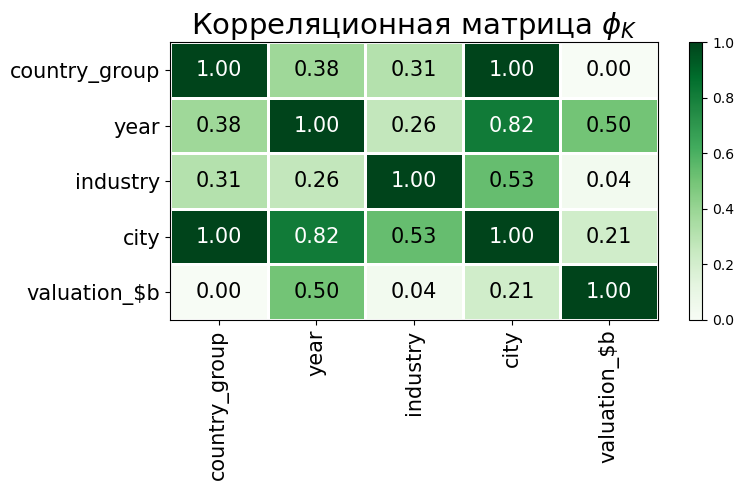

In [135]:
interval_cols = ['valuation_$b']

phik_overview = corr_data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляционная матрица $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(8, 5))
plt.tight_layout()

Обработаем матрицу, чтобы избавиться от дублирующих значений.

In [136]:
mask = np.zeros_like(phik_overview, dtype=bool)
mask[np.triu_indices_from(mask)] = True
phik_overview[mask] = np.nan

In [137]:
phik_overview.drop(['valuation_$b'],axis=0, inplace=True)

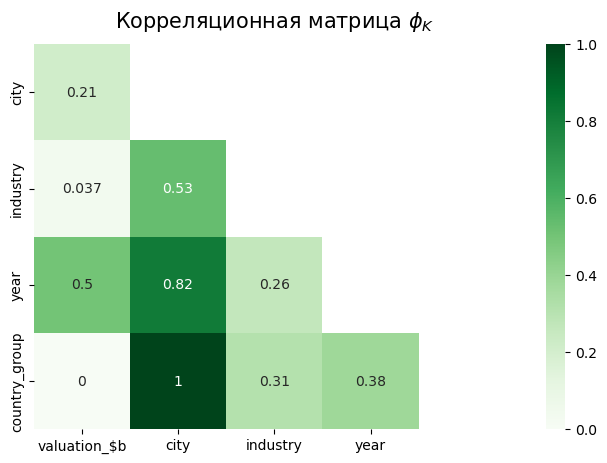

In [138]:
plt.figure(figsize=(8,5))
ax = sns.heatmap(phik_overview,
    cmap="Greens", annot=True,
    vmin=0, vmax=1.0,
    square=True, yticklabels=phik_overview.index, 
                 xticklabels=phik_overview.columns.drop(['country_group']))
ax.set_title('Корреляционная матрица $\phi_K$', fontdict={'fontsize':15}, pad=12)
plt.show()

Видим, что страна не влияет на стоимость компаний. Когда мы проверяли гипотезы, мы не обнаружили значимой разницы в медианной стоимости компаний у всех пар стран кроме США и Китая. Можно сказать, что это согласуется с выводом, что корреляции у стоимости компаний со страной нет.\
Значимая корреляция со стоимостью есть только у столбца с годами. И мы это связь уже видели, так как с 2013 года начинается значительный рост количества новых единорогов.\
У отраслей есть заметная корреляция с городом, но со странами не такая большая.\
В целом, таблица подтверждает те выводы, которые я сделал раньше. 

## Корреляция городов и отраслей

Можно отдельно посмотреть на топ-10 городов по каждой отрасли, чтобы предположить о какой корреляции может идти речь в случае городов и ораслей.

In [139]:
ME = data[data['industry']=='Media & Entertainment']['valuation_$b']   
Ind = data[data['industry']=='Industrials']['valuation_$b'] 
FS = data[data['industry']=='Financial Services']['valuation_$b'] 
CR = data[data['industry']=='Consumer & Retail']['valuation_$b'] 
HL = data[data['industry']=='Healthcare & Life Sciences']['valuation_$b'] 
ET = data[data['industry']=='Enterprise Tech']['valuation_$b']

**Начнем с отрасли "Enerprise Tech"**.

In [140]:
def top_cities(industry):
    city = data[data['industry']==industry].groupby(
    by=['city','country'])['company'].count().reset_index().sort_values(by='company', ascending=False).head(10)
    
    ax = sns.barplot(x='city', y='company', data=city)

    plt.xticks(rotation=90)

    plt.title(f'Топ-10 городов по количеству стартапов из отрасли {industry}')

    plt.ylabel('кол-во') 

    plt.xlabel('города')

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center')

    plt.show()

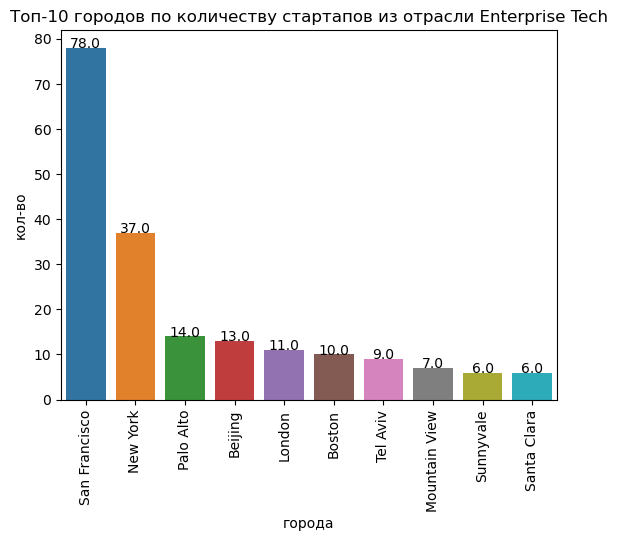

In [141]:
top_cities('Enterprise Tech')

Почти все города из США. Из Китая только Пекин. В лидерах Сан-Франциско и Нью-Йорк.

**Теперь "Healthcare & Life Sciences"**.

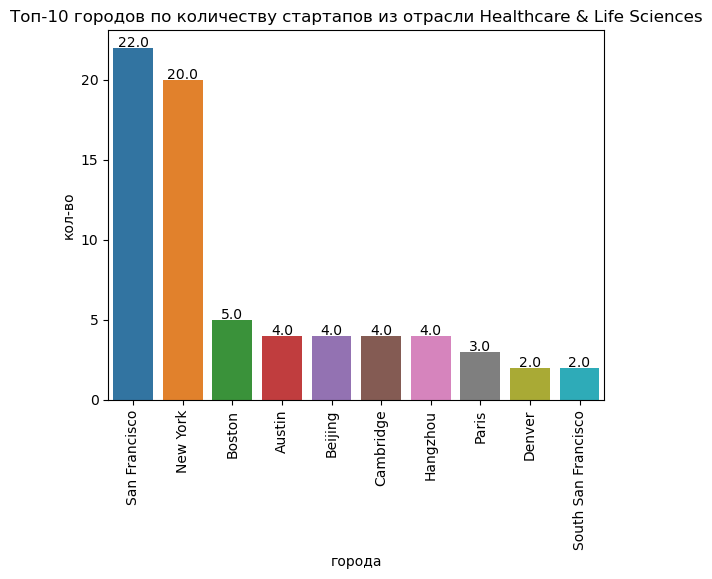

In [142]:
top_cities('Healthcare & Life Sciences')

Снова Сан-Франциско и Нью-Йорк в лидерах, есть только два города из Китая, а также Кэмбридж из Англии и Париж из Франции.

**"Consumer & Retail"**.

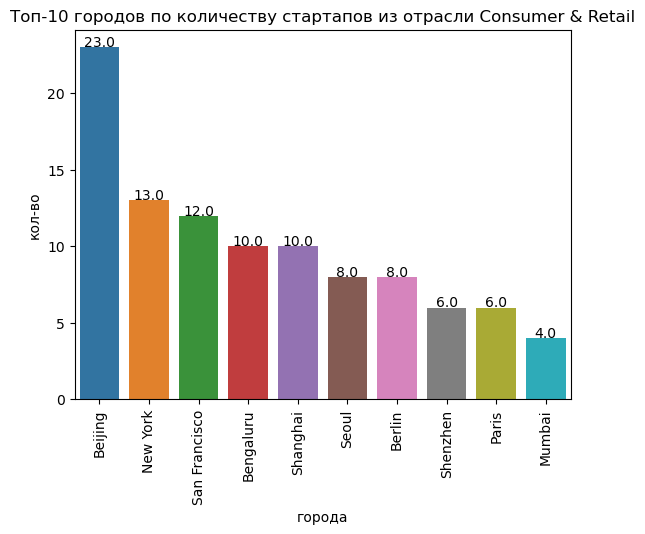

In [143]:
top_cities('Consumer & Retail')

Тут видим гораздо больше разнообразия. Есть три города из Китая, два из Индии и два из США. В Китае и Индии большое население, поэтому стартапы, связанные с потребительскими товарами процветают.\
Из США снова Нью-Йорк и Сан-Франциско. А из Китая Пекин, Шанхай и Шеньчжень.

**"Financial Services"**.

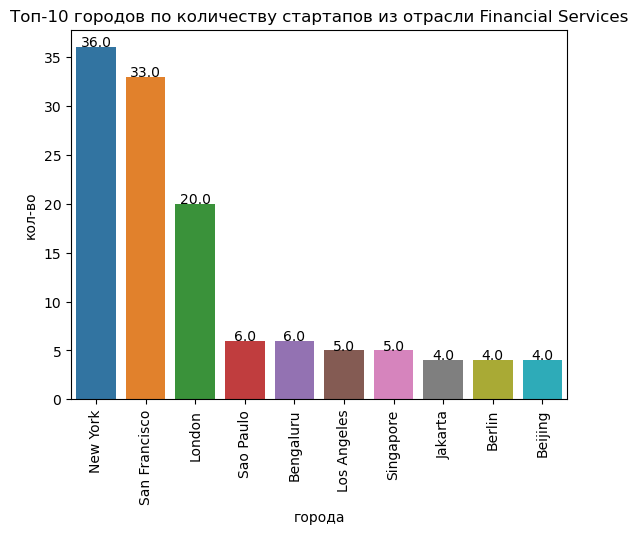

In [144]:
top_cities('Financial Services')

Снова есть разнообразие. Из США три города, из Китая, Великобритании, Индии, Бразилии, Сингапура, Индонезии, Германии - один.

**"Industrials"**.

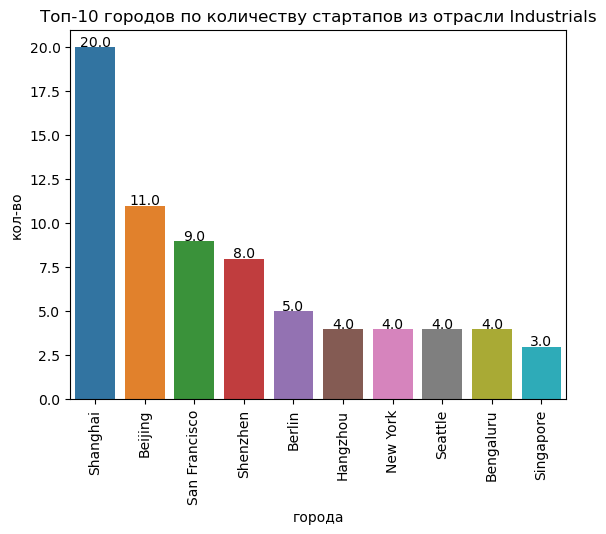

In [145]:
top_cities('Industrials')

Четыре города из Китая, три из США. По одному из Германии, Индии, Сингапура.\
Из Китая в лидерах Шанхай и Пекин.

**"Media & Entertainment"**.

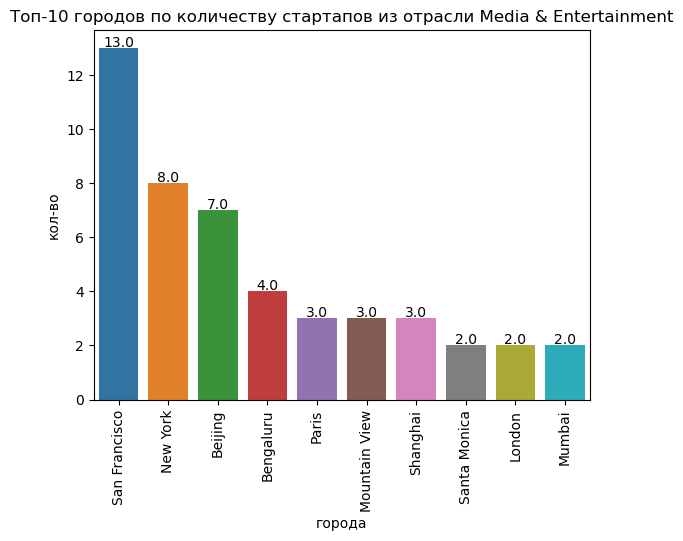

In [146]:
top_cities('Media & Entertainment')

4 города из США, 2 из Китая и Индии, один из Великобритании и Франции.

Действительно заметно, что в зависимости от отрасли меняются города и страны.\
Чаще всего больше всего стартапов в Нью-Йорке, Сан-Франциско, Пекине, Шанхае и Бангалоре. Это явные лидеры.

## Выводы к разделу с корреляцией

* Корреляции у стоимости компаний со страной нет. Это согласуется с результатами статистического, что нет значимой разницы между медианными стоимостями компаний в странах.
* Значимая корреляция со стоимостью есть только у столбца с годами.
* У отраслей есть заметная корреляция с городом, но со странами не такая большая:
  * у отрасли 'Enterprise Tech' по количеству стартапов в топ-10 городов почти все города из США. Из Китая только Пекин;
  * у отрасли 'Healthcare & Life Sciences' cнова Сан-Франциско и Нью-Йорк в лидерах, есть только два города из Китая, а также Кэмбридж из Англии и Париж из Франции;
  * у отрасли 'Consumer & Retail' в топ 10 городов по количеству компаний eсть три города из Китая, два из Индии и два из США. В Китае и Индии большое население, поэтому стартапы, связанные с потребительскими товарами процветают.
  * у 'Financial Services' снова есть разнообразие. Из США три города, из Китая, Великобритании, Индии, Бразилии, Сингапура, Индонезии, Германии - один.
  * у 'Industrials' в основном США и Китай.
  * у 'Media & Entertainment' большинство компаний из США, Китая и Индии.
  
То есть можно сделать вывод, что в отраслях, где основной покупатель - физические лица много компаний из основных индийских и китайских мегаполисов. Но при этом почти в каждой отрасли стабильно присутствуют Нью-Йорке и Сан-Франциско.

# Итоговые выводы по проекту:

* США, Китай, Индия и Великобритания лидеры по количеству стартапов-единорогов. Компаний из США больше всего, 54% всех компаний.
* По стоимости стартапов-единорогов лидеры те же. По совокупной стоимости стартапы из США снова имеют долю 54%.
* За период с 2015 по 2018 год количество новых компаний в Китае каждый год было больше, чем во всех других странах.
* С 2018 года количество новых компаний в Китае стагнирует, а в 2022 году и вовсе их было меньше, чем во всех рассматриваемых странах на графике. Конкретно про 2022 год, скорее всего - это эффект того, что Китай очень долго оставлял строгие ограничения из-за ковида, и экономика сильно страдала от этого. В 2022 году почти все серьезные ограничения в других странах были сняты, а в Китае еще нет.
* В Индии за период 2020-2022 годов заметно выросло число новых единорогов. Индия обогнала Великобританию и Китай.
* В странах категории "Другие", начиная с 2020 года новых единорогов появляется значительно больше, чем за другие года. Эти страны в совокупности не обогнали только США, если брать 2020-2022 года.
* США с 2018 года - лидер по кол-ву новых компаний. В 2022 году было снижение, как и у всех других стран.
* Нет страны, которая имела бы значимо более дорогие или более дешевые стартапы. 
Во всех случаях кроме сравнения США и Китая статистический тест нам говорит, что выборки могли прийти из одной генеральной совокупности. А значит, мы для таких выборок не можем сказать, что у них разные медианы.\
У Китая и США медианные стоимости стартапов равны 1.4 и 1.7 соответственно. Статистический тест показал, что для наших выборок - это значимое различие. Поэтому мы можем считать, что компании из этих стран имеют разную стоимость, а в США наша медиана оказалась выше.

-----------------
* В наших данных больше всего компаний из сектора Enterprise Tech.
* Стартапы в области финансовых услуг и из области розничной торговли и товаров широкого потребления тоже популярны.
* У медианной стоимости по отраслям разброс небольшой. Все стоимости уложились в диапазон от 1.5 до 1.9 млрд. долл. включительно. 
* Различия в медианной стоимости по отраслям статистически не значимы. То есть в действительности, мы не можем сказать, что один сектор имеет более дорогие компании, чем другие.
* До 2017 года лидером по количеству новых единорогов был сектор потребительских товаров и розничной торговли. На конец 2022 года этот сектор занимает 4 место.
* С 2017 года бессменный лидер - сектор технологий для улучшения бизнес-процессов.
* С 2020 года вышел на второе место резким рывком сектор финансовых услуг.
* Ожидаемо в аутсайдерах по количеству компаний почти на протяжении всех лет сектора страхования и медиа и развлечений. Возможно, в этих секторах действительно сложно создать крупный, успешный бизнес, оцениваемый в 1 млрд. долл. и более.
----------------
За последние несколько лет в Индии появляется больше новых стартапов-единорогов, чем в Китае и Великобритании. Больше единорогов только в США.  Это значит, что в Индии последние несколько лет благоприятный климат для развития компаний. При этом больше всего единорогов в Индии в Бангалоре и достаточно много в Мумбаи. \
Бангалор и Мумбаи входят в топ-10 городов по количеству единорогов в секторах 'Consumer & Retail' и 'Media & Entertainment'. Только Бангалор вдобавок к этому, входит в топ-10 городов в секторе 'Financial Services'.  В Индии население почти 1.5 млрд. человек. Поэтому не удивительно, что сектора, где много стартапов из Индии связаны именно с физическими лицами и потребительским спросом.\
Сектор 'Media & Entertainment' имеет мало единорогов по сравнению с другими секторами, поэтому, вероятнее всего компаниям этого сектора тяжело достичь оценку в 1 млрд. долл.
Сектор 'Financial Services' с 2020 года вышел на второе место по числу новых единорогов. Это значит, что есть спрос и стартапы из этого сектора активно развиваются во всем мире. Это говорит и о конкуренции и о возможности выйти за пределы Индии.

Мой анализ не выявил различий в медианных стоимостях стартапов основных стран, кроме сравнения Китая и США, поэтому нельзя сказать, что стартапы какой-то страны заметно выделяются по стоимости. Но при сравнении Китая и США значимые различия обнаружены, а у США медиана стоимости выше, чем у Китая.
Плюс США с 2018 года лидер по количеству новых компаний-единорогов. Города Сан-Франциско и Нью-Йорк находятся в тройке городов по числу стартапов в секторах: 'Consumer & Retail',  'Financial Services',  'Media & Entertainment' , 'Healthcare & Life Sciences' и 'Enterprise Tech'. 
При этом именно сектор 'Enterprise Tech' с 2017 года каждый год прирастает на большее число компаний-единорогов.

В итоге можно выделить два направления для фонда к которым можно присмотреться:
1)	Стартапы из Бангалора, работающие в 'Consumer & Retail'  и, в особенности, в  'Financial Services'.

2)	Стартапы из Нью-Йорка и Сан-Франциско,  работающие в секторах: 'Enterprise Tech' и 'Financial Services'.
